In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import time
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
column_names = [
    "age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
    "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
    "hours_per_week", "native_country", "income"
]

# Read the dataset with the correct column names
df = pd.read_csv("/content/drive/MyDrive/MLProject/census_income/adult.data", names=column_names, sep=",", skipinitialspace=True)

# Display the first few rows
df.head(5)

age         workclass  fnlwgt  education  education_num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital_status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital_gain  capital_loss  hours_per_week native_country income  
0          2174             0              40  United-States  <=50K  
1             0             0              13  United-States  <=50K  
2             0             0              40  United-States  <=50K  
3             0             0              40  United-States  <=50K  
4             0             0              40           Cuba  <=50K

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


# Explore fnlweight

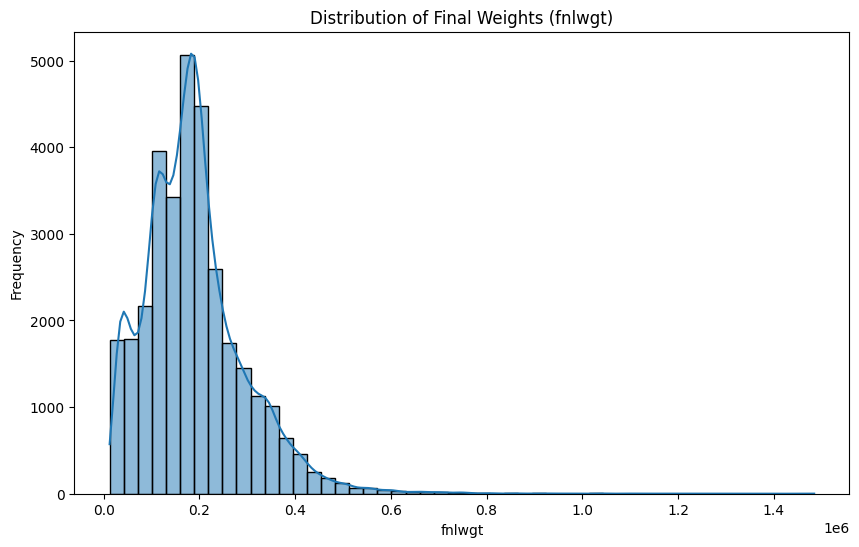

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df["fnlwgt"], bins=50, kde=True)
plt.title("Distribution of Final Weights (fnlwgt)")
plt.xlabel("fnlwgt")
plt.ylabel("Frequency")
plt.show()

In [6]:
df.groupby("race")["fnlwgt"].mean().sort_values(ascending=False)

race
Black                 228013.124200
Other                 197124.191882
White                 187298.064280
Asian-Pac-Islander    159940.609240
Amer-Indian-Eskimo    120831.147910
Name: fnlwgt, dtype: float64

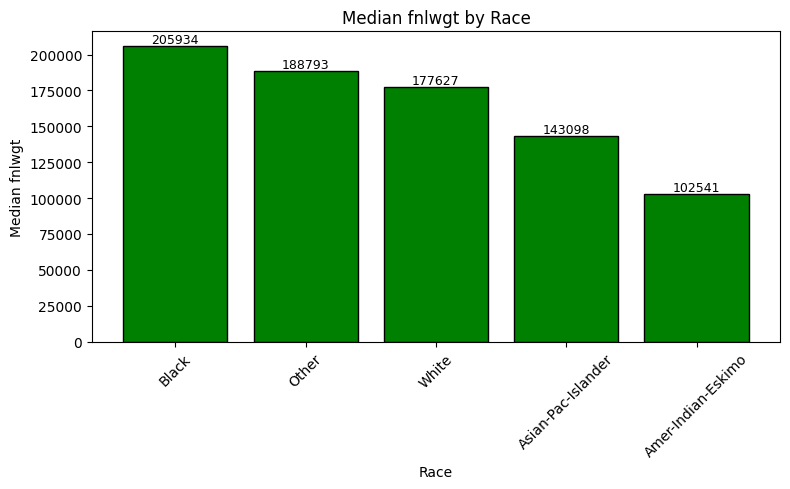

In [7]:
import matplotlib.pyplot as plt

# Calculate the median fnlwgt by race
median_fnlwgt_by_race = df.groupby("race")["fnlwgt"].median().sort_values(ascending=False)

# Plot as bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(median_fnlwgt_by_race.index, median_fnlwgt_by_race.values, color='green', edgecolor='black')
plt.title("Median fnlwgt by Race")
plt.ylabel("Median fnlwgt")
plt.xlabel("Race")
plt.xticks(rotation=45)

# Add number labels on each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [8]:
import pandas as pd

# Replace 'target' with your actual target variable name
target_col = 'income'
columns_to_check = ['race', 'sex']

# Store results in a dictionary
result_tables = {}

for col in columns_to_check:
    # Calculate % distribution of target within each feature class
    dist = df.groupby(col)[target_col].value_counts(normalize=True).unstack().fillna(0) * 100
    result_tables[col] = dist.round(2)

# Display one table at a time
for col, table in result_tables.items():
    print(f"\nDistribution of target variable by '{col}':\n")
    print(table)



Distribution of target variable by 'race':

income              <=50K   >50K
race                            
Amer-Indian-Eskimo  88.42  11.58
Asian-Pac-Islander  73.44  26.56
Black               87.61  12.39
Other               90.77   9.23
White               74.41  25.59

Distribution of target variable by 'sex':

income  <=50K   >50K
sex                 
Female  89.05  10.95
Male    69.43  30.57


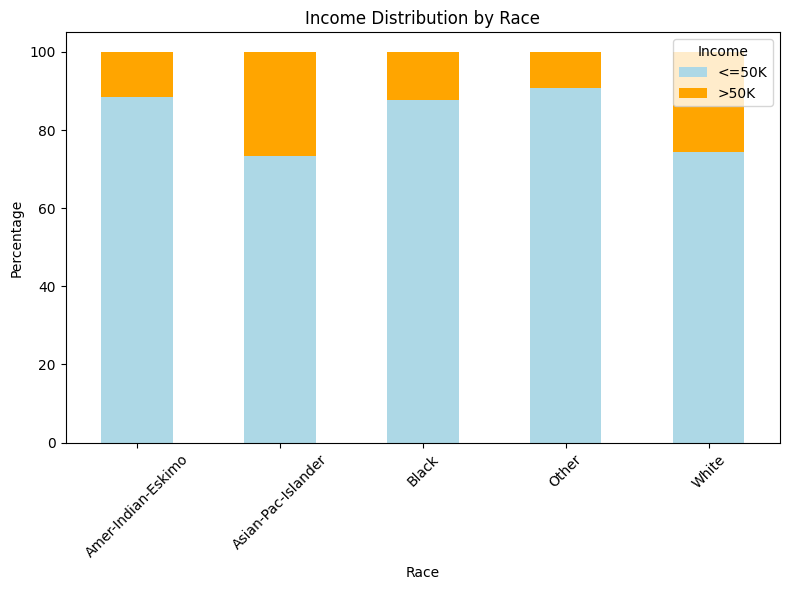

In [9]:
import matplotlib.pyplot as plt

# Get the distribution table for race
race_dist = result_tables['race']

# Plot as a stacked bar chart
race_dist.plot(kind='bar', stacked=True, figsize=(8, 6), color=['lightblue', 'orange'])

# Add labels and title
plt.title("Income Distribution by Race")
plt.xlabel("Race")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.legend(title="Income")
plt.tight_layout()
plt.show()


# Distribution of Numerical Data

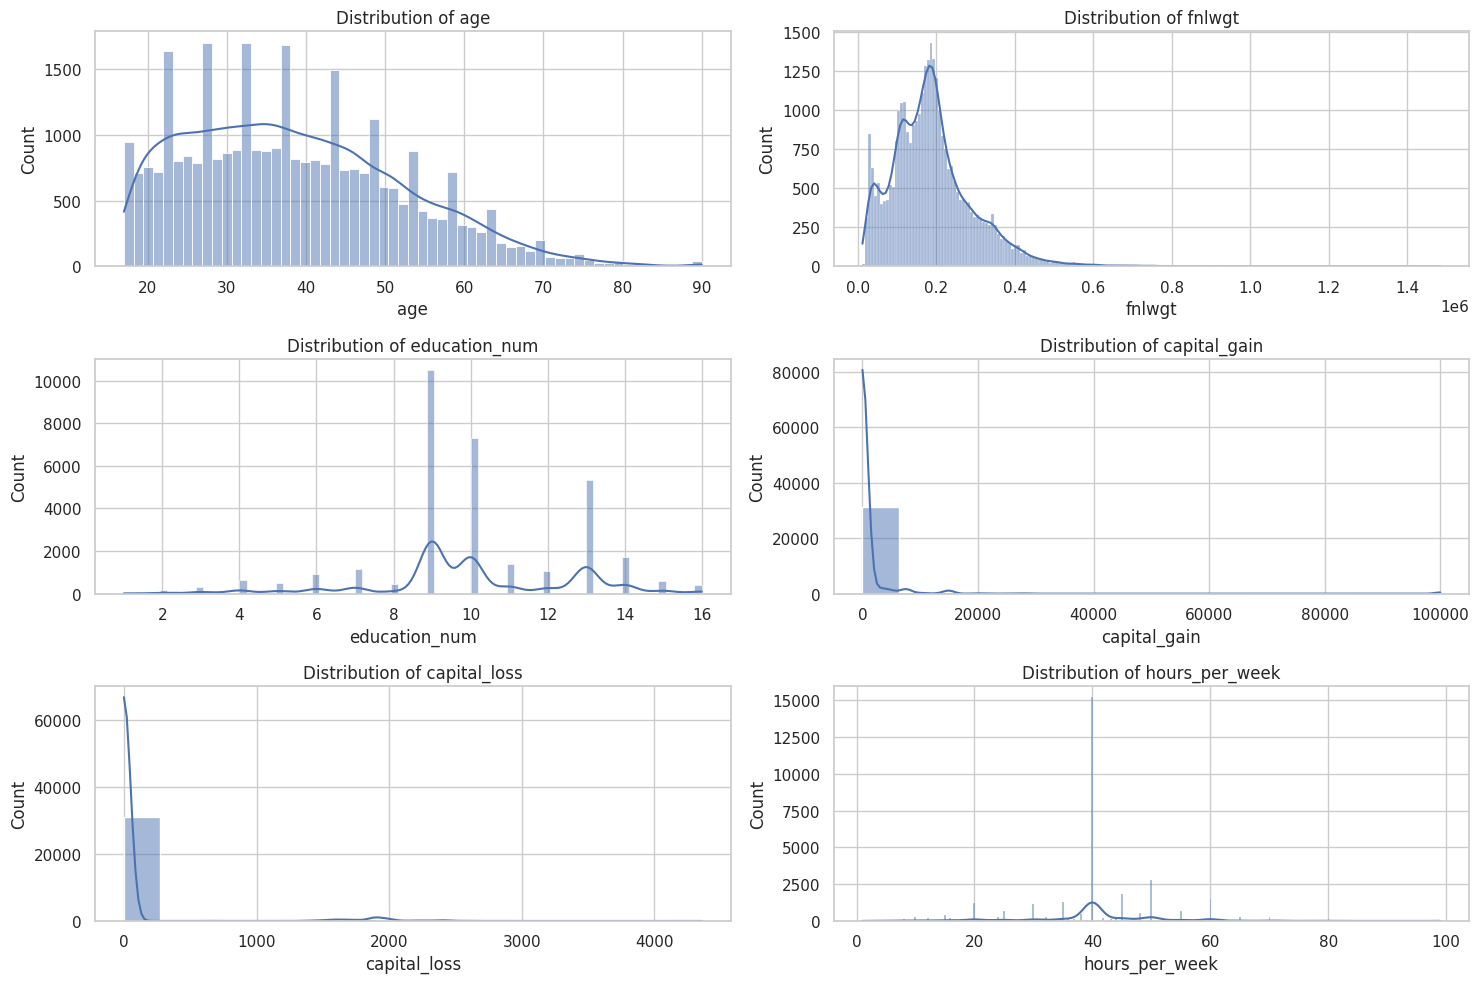

In [10]:
# Set general style
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))
#define numerical and categorical features
numerical = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

for i, col in enumerate(numerical):
    plt.subplot(3, 2, i+1)
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Numerical features vs income

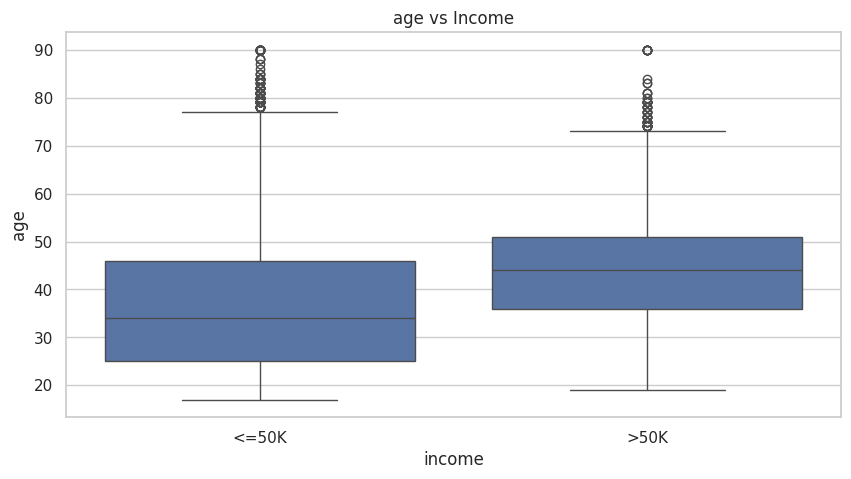

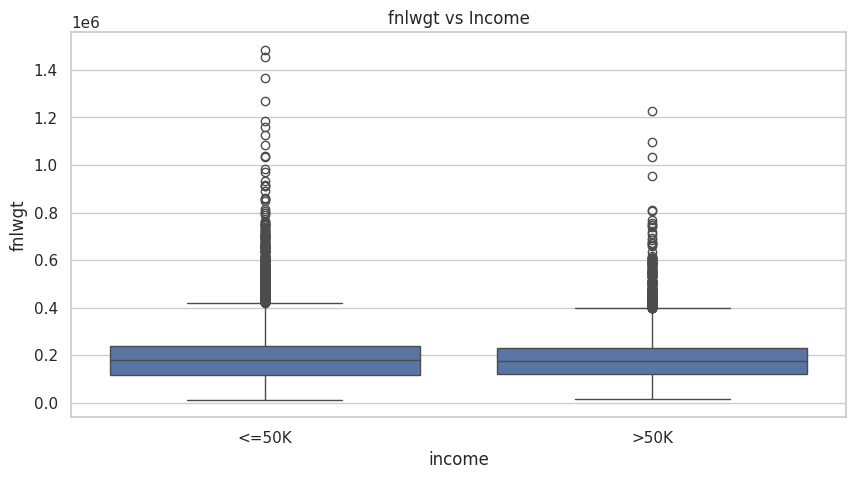

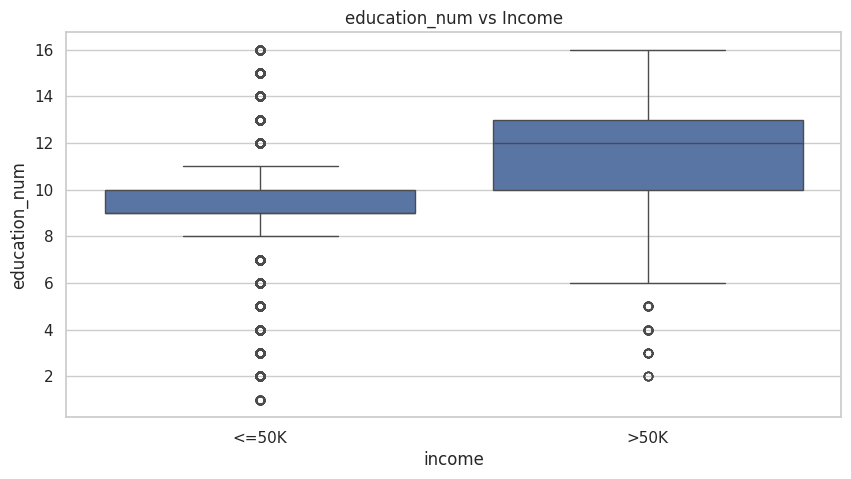

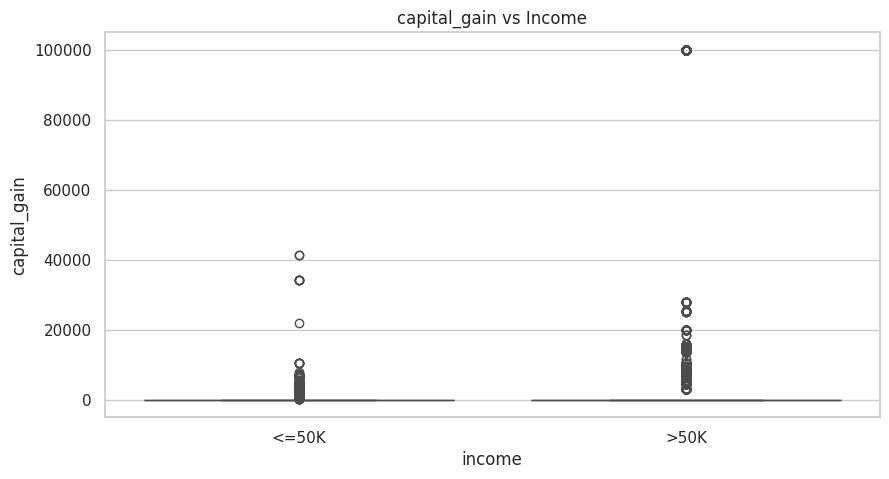

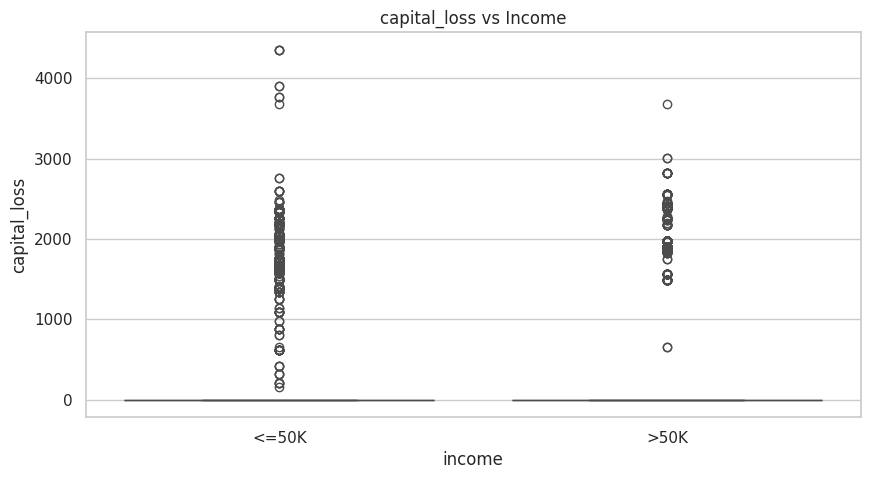

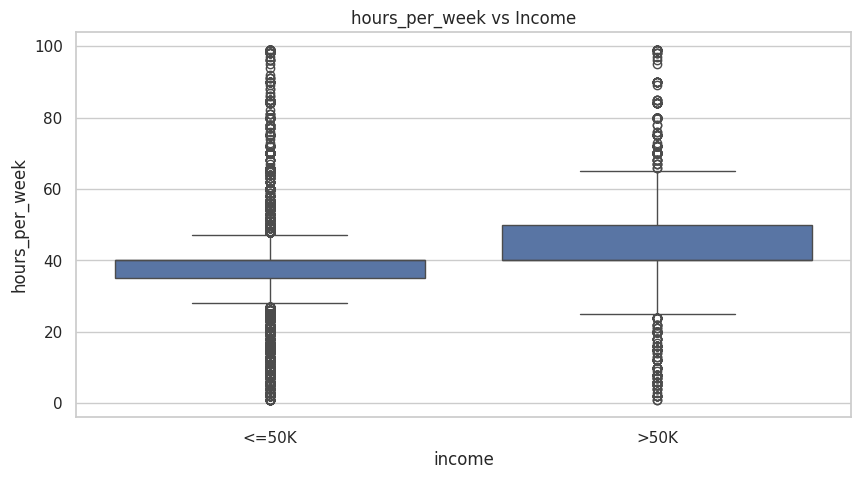

In [11]:
for col in numerical:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x='income', y=col)
    plt.title(f'{col} vs Income')
    plt.show()

In [12]:
def age_group(x):
  x = int(x)
  if( 16 < x < 26):
    return "17-25"
  if( 25 < x < 31 ):
    return "26-30"
  if( 30 < x < 36 ):
    return "31-35"
  if( 35  < x < 41 ):
    return "36-40"
  if( 40 < x < 46 ):
    return "41-45"
  if( 45 < x < 51 ):
    return "46-50"
  if( 50 < x < 56 ):
    return "51-55"
  if( 55 < x < 61 ):
    return "56-60"
  if( 60 < x < 66 ):
    return "61-65"
  if( 65 < x < 71 ):
    return "66-70"
  else:
    return "Greater than 70"

df['age_group'] = df['age'].apply(age_group)

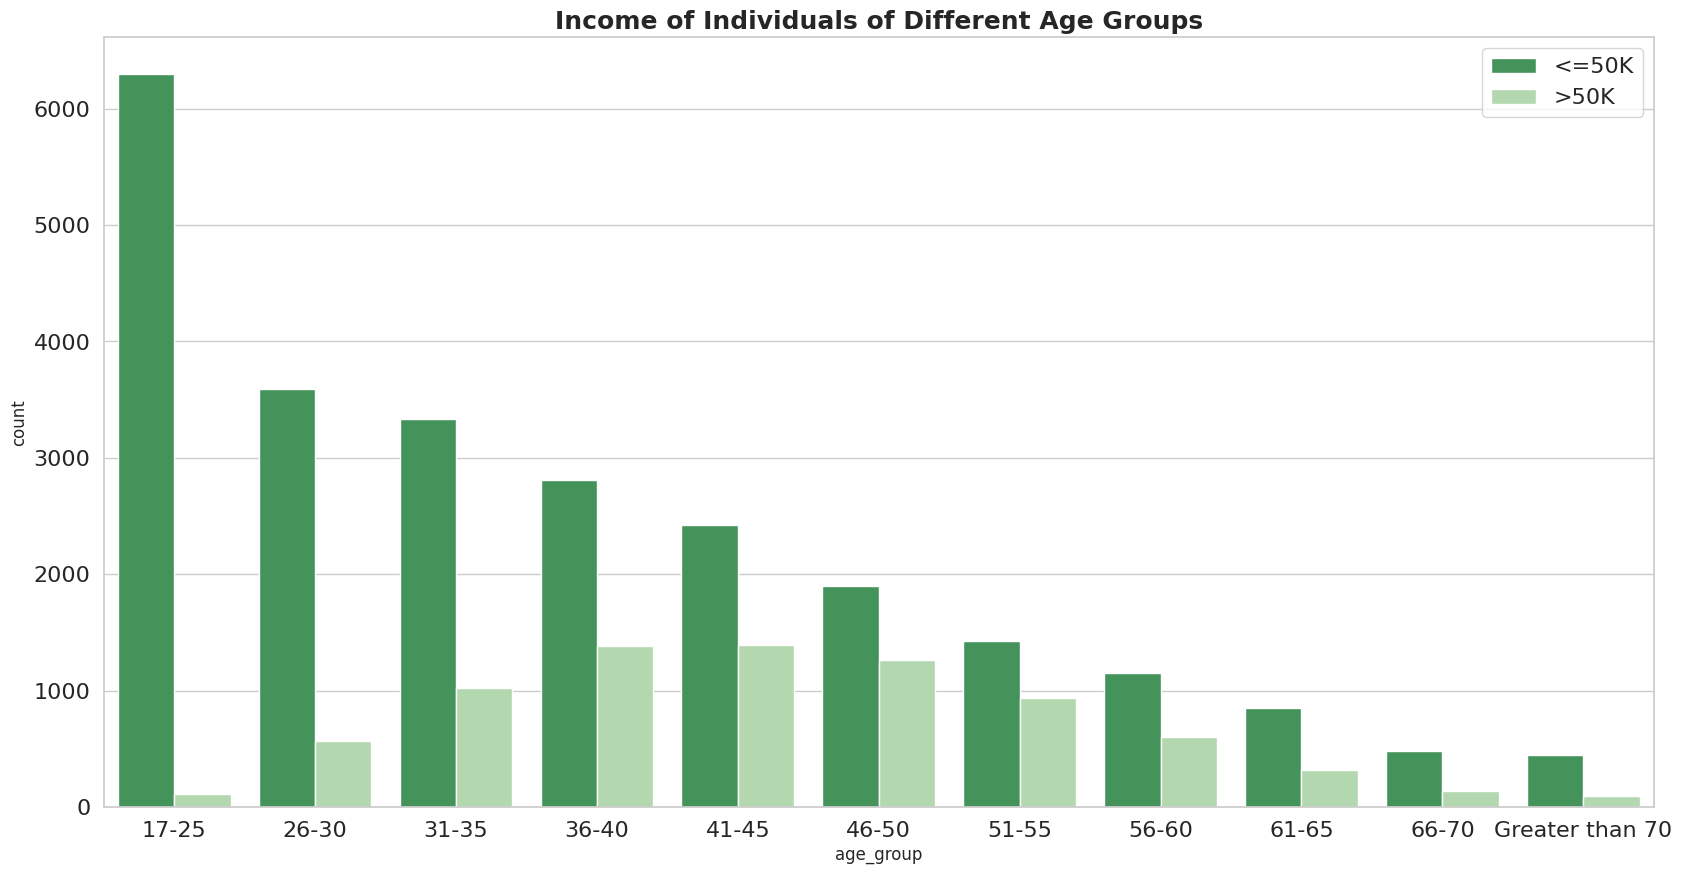

In [13]:
plt.figure(figsize=(20,10))
order_list = ['17-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65','66-70', 'Greater than 70']
# Melt the dataframe to long-form
df_melted = pd.melt(df, id_vars=['age_group'], value_vars=['income'], var_name='Income', value_name='Count')

# Use countplot with melted dataframe
sns.countplot(x='age_group', hue='Count', data=df_melted, palette='Greens_r', order=order_list)

plt.title('Income of Individuals of Different Age Groups', fontsize=18, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [14]:
age_income = df.groupby('age_group')['income'].value_counts(normalize=True).unstack() * 100
print(age_income['>50K'].sort_values(ascending=False))

age_group
46-50              39.911588
51-55              39.730072
41-45              36.451782
56-60              34.433694
36-40              32.983544
61-65              27.086882
31-35              23.501034
66-70              22.491909
Greater than 70    17.407407
26-30              13.650565
17-25               1.778194
Name: >50K, dtype: float64


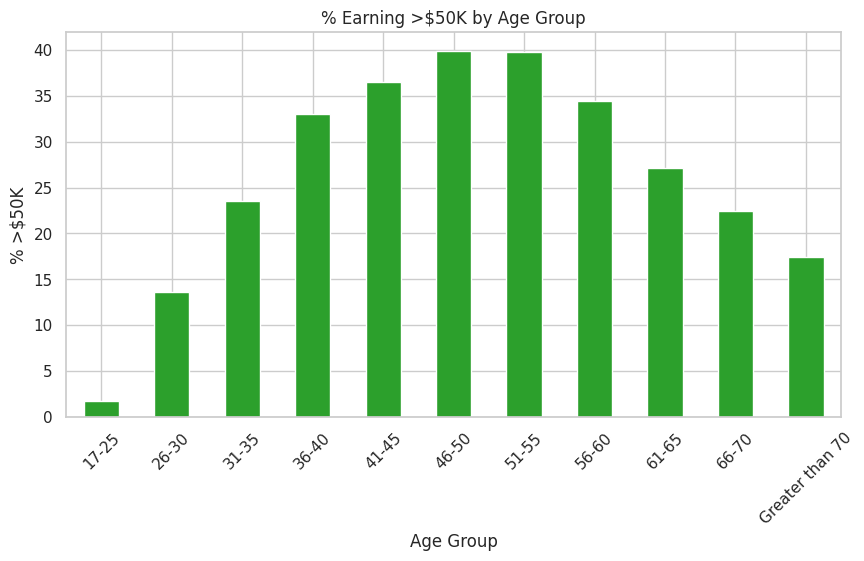

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
plt.figure(figsize=(10, 5))
age_income['>50K'].sort_index().plot(kind='bar', color='#2ca02c')
plt.title("% Earning >$50K by Age Group")
plt.xlabel("Age Group")
plt.ylabel("% >$50K")
plt.xticks(rotation=45)
plt.savefig('age_income.png')
plt.show()
files.download('age_income.png')

### Age with Occupation

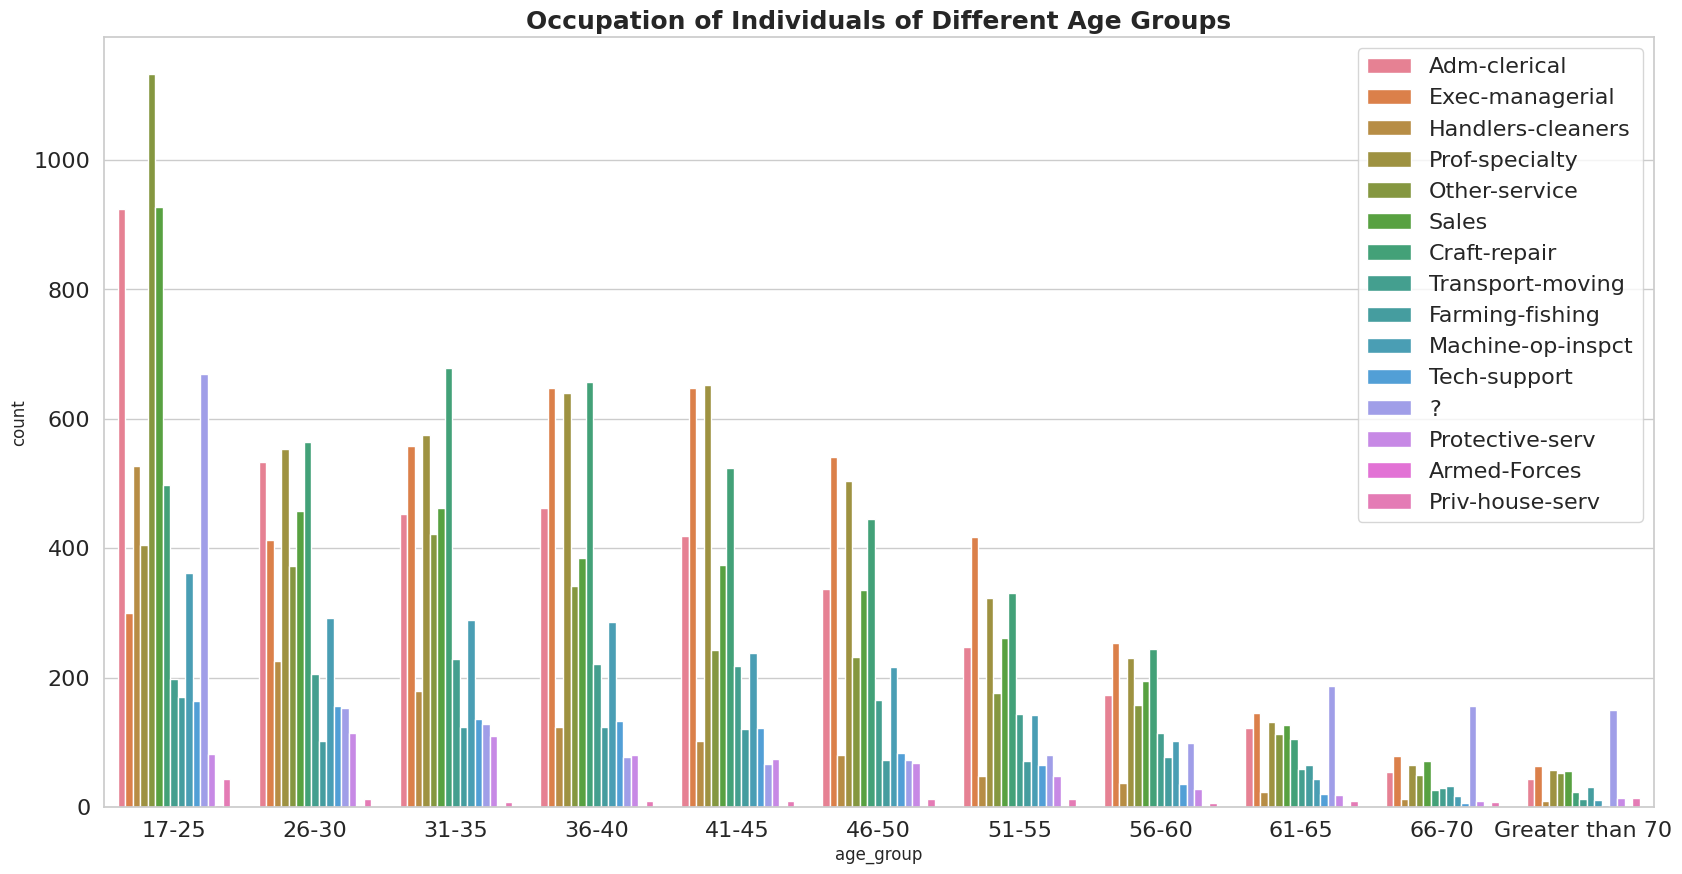

In [16]:
plt.figure(figsize=(20,10))
# Melt the dataframe to long-form
df_melted = pd.melt(df, id_vars=['age_group'], value_vars=['occupation'], var_name='Occupation', value_name='Count')

# Use countplot with melted dataframe
sns.countplot(x='age_group', hue='Count', data=df_melted, order=order_list)

plt.title('Occupation of Individuals of Different Age Groups', fontsize=18, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

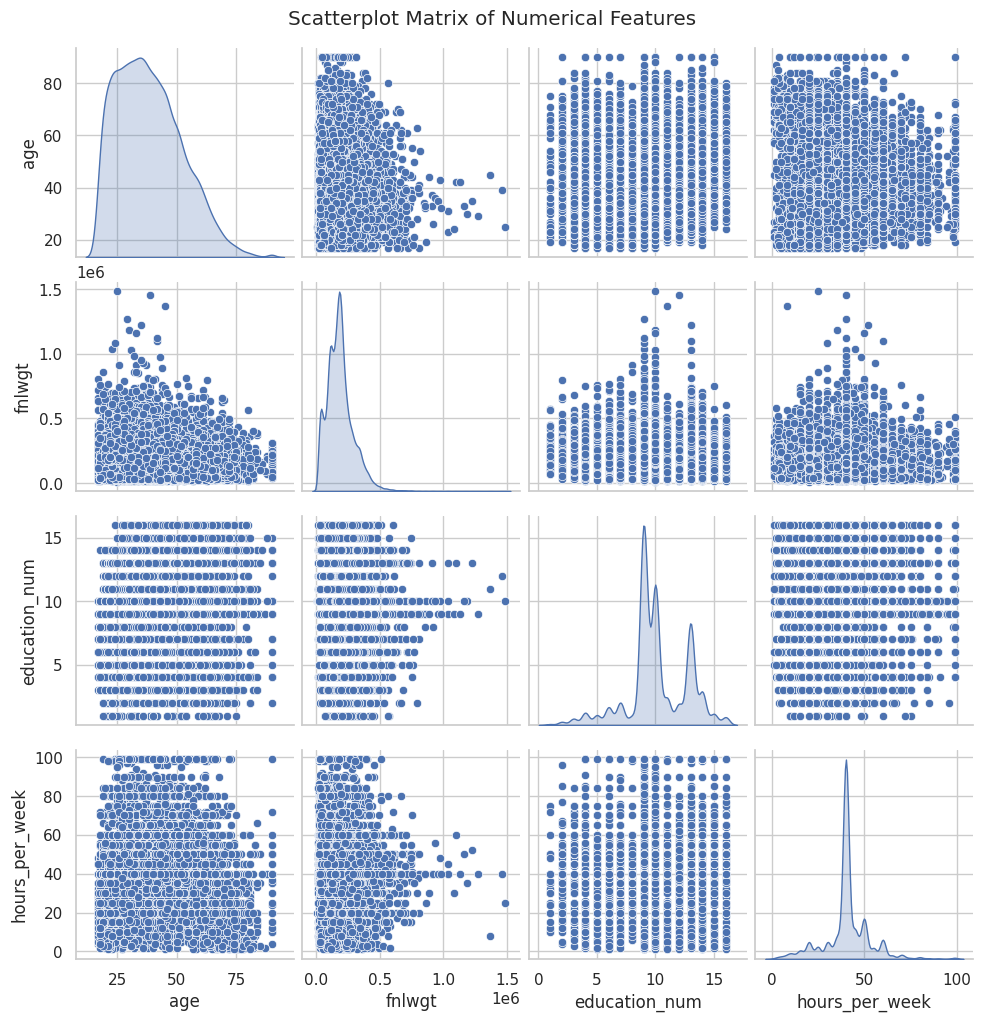

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns
numerical_cols = ['age', 'fnlwgt', 'education_num', 'hours_per_week']

# Scatterplot matrix (pairplot)
sns.pairplot(df[numerical_cols], diag_kind='kde')
plt.suptitle("Scatterplot Matrix of Numerical Features", y=1.02)
plt.show()


there is no linearity between the numerical features

So now, depending on your goal:
If you want linear models (e.g., Linear Regression, Logistic Regression), you may transform features.

Example: polynomial features, binning, interaction terms.

Otherwise, for nonlinear models (e.g., Decision Trees, Random Forests, Gradient Boosting, XGBoost), no need to force linearity — those models can handle nonlinear patterns well!

## EDA for Categorical data

### Count plots for categorical features

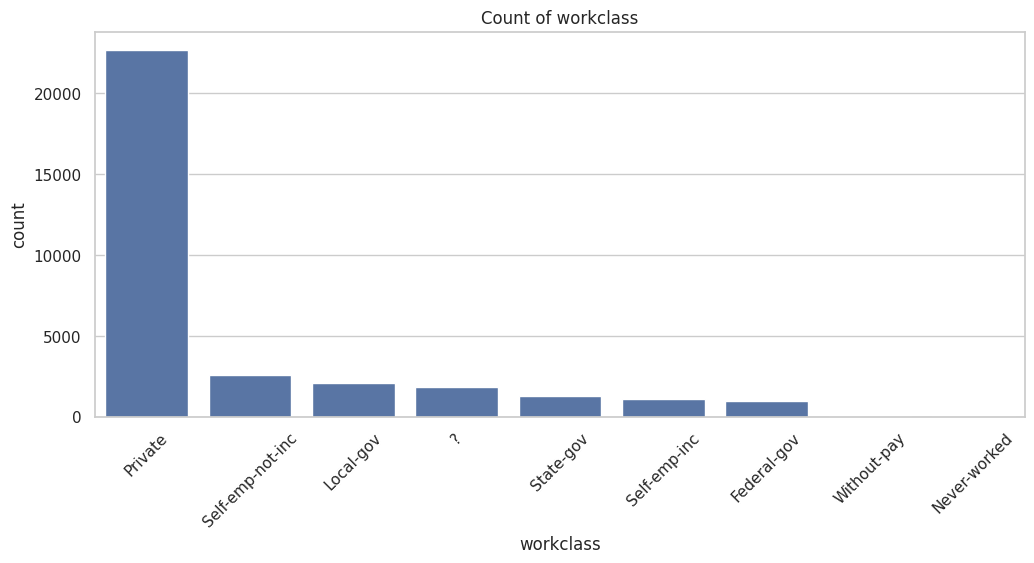

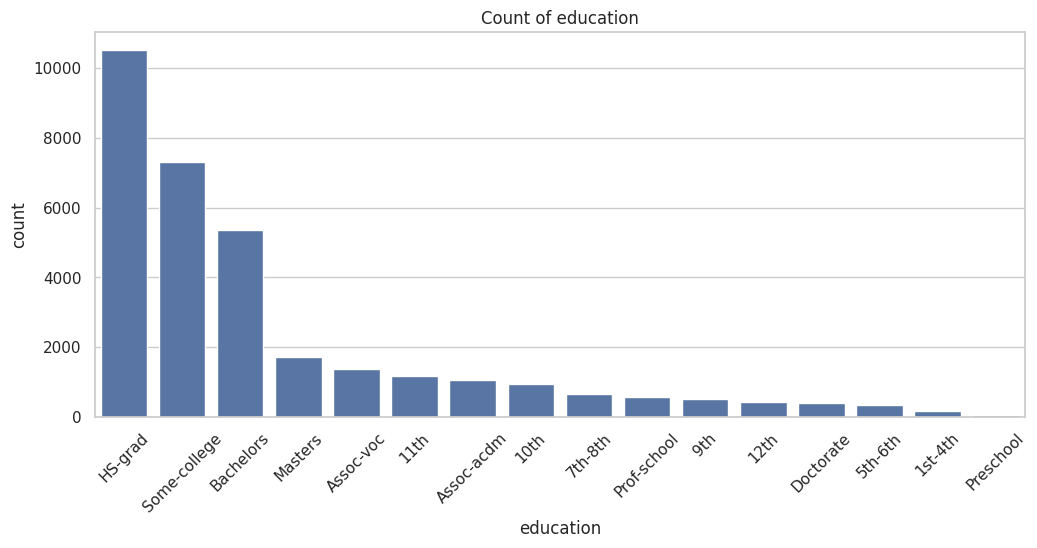

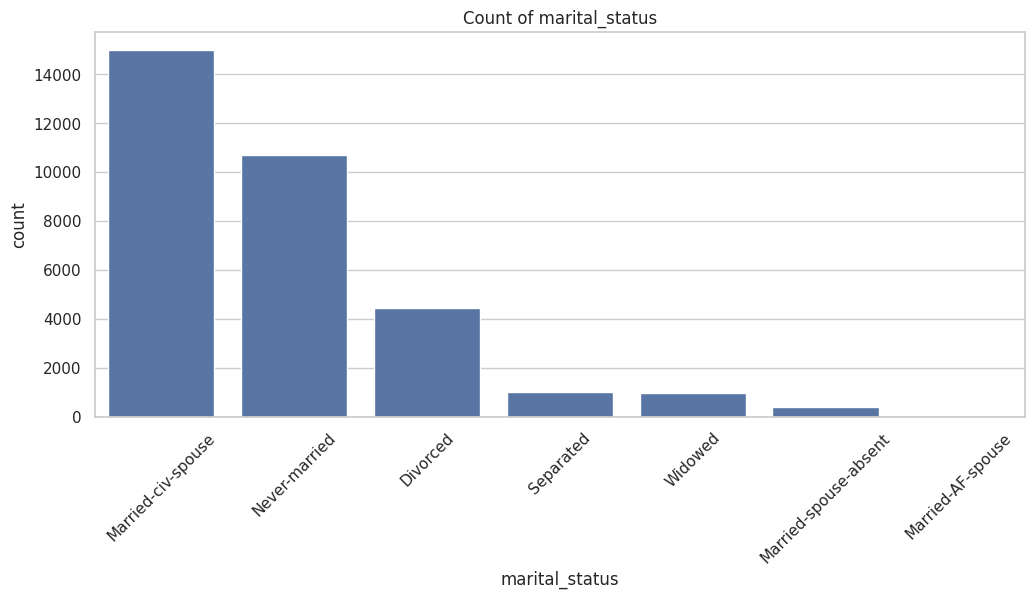

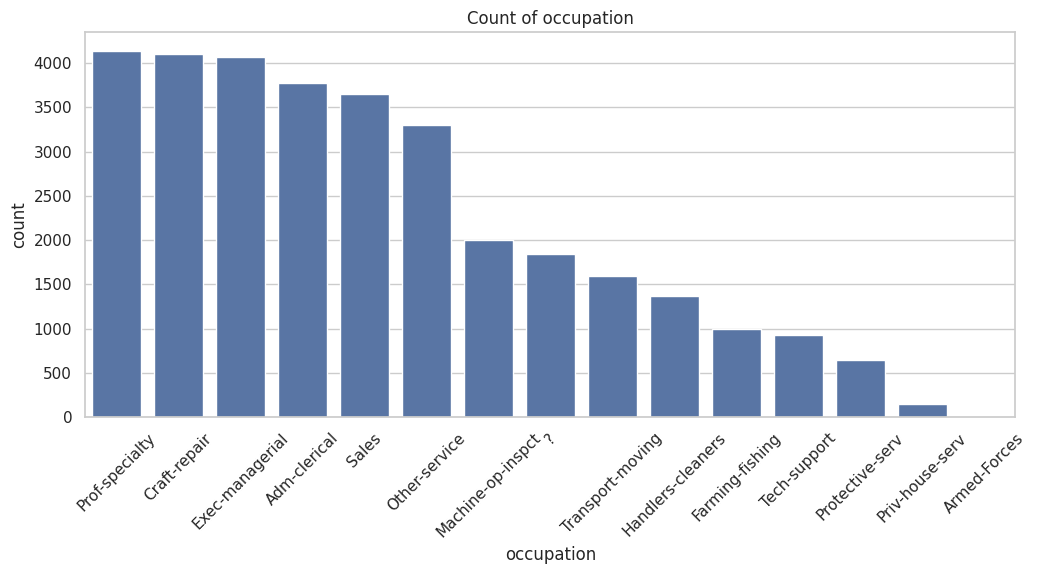

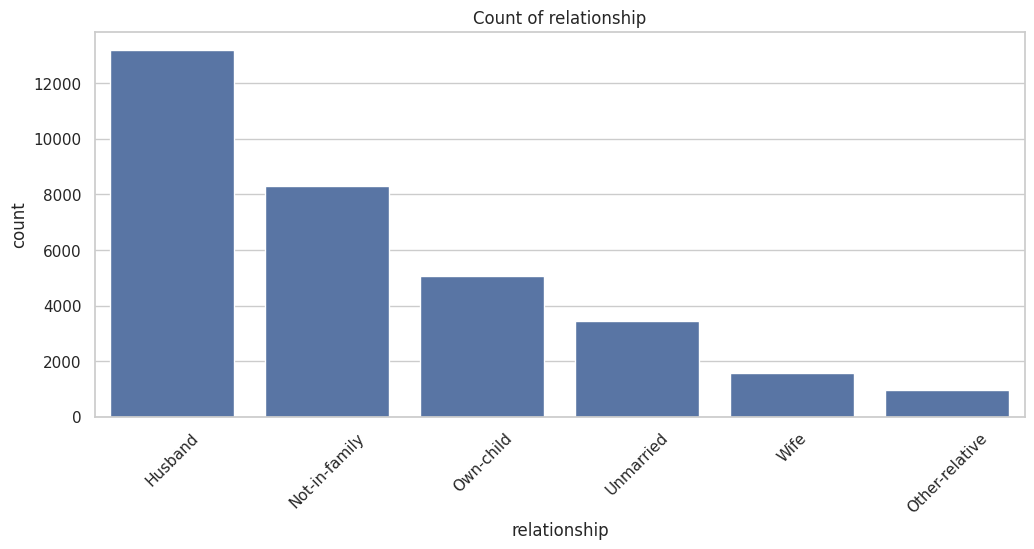

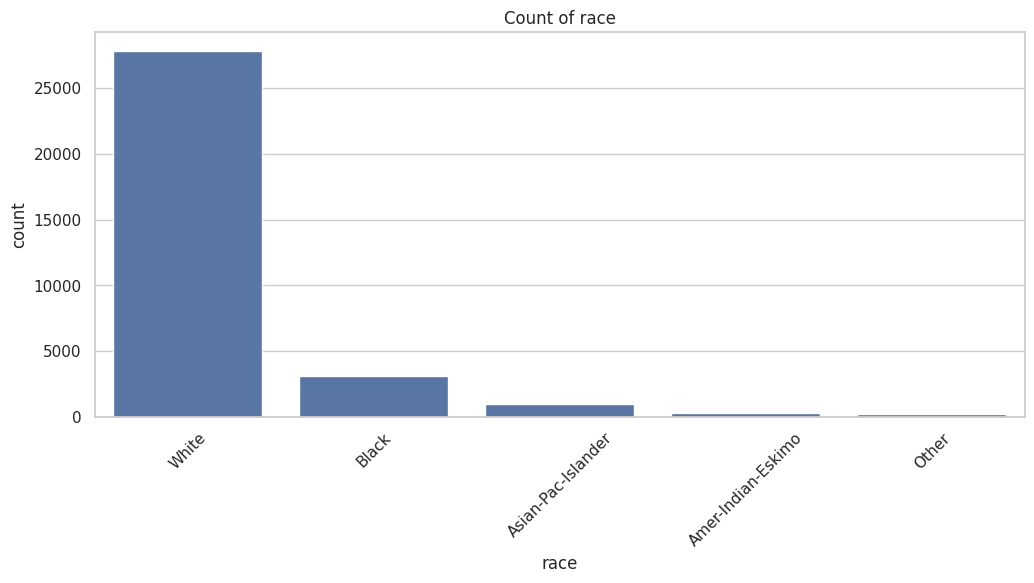

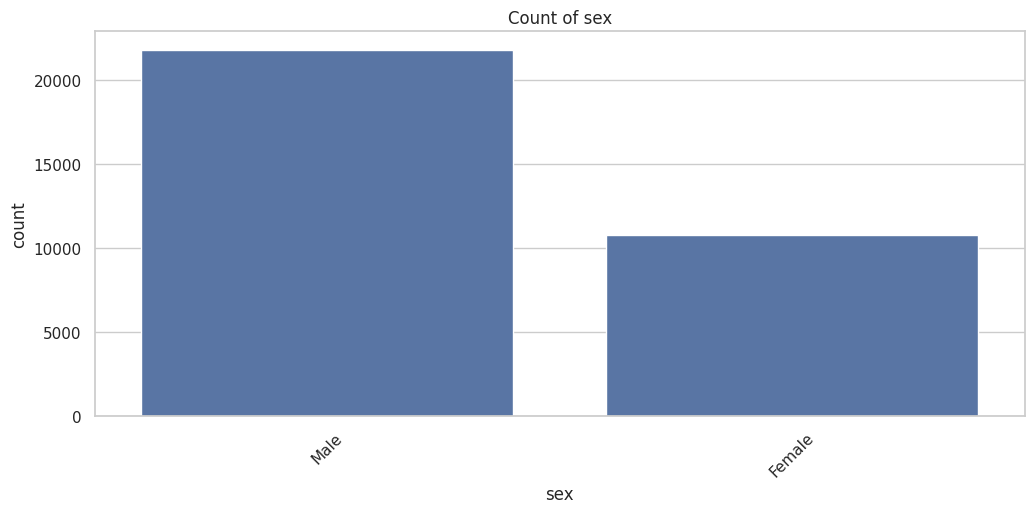

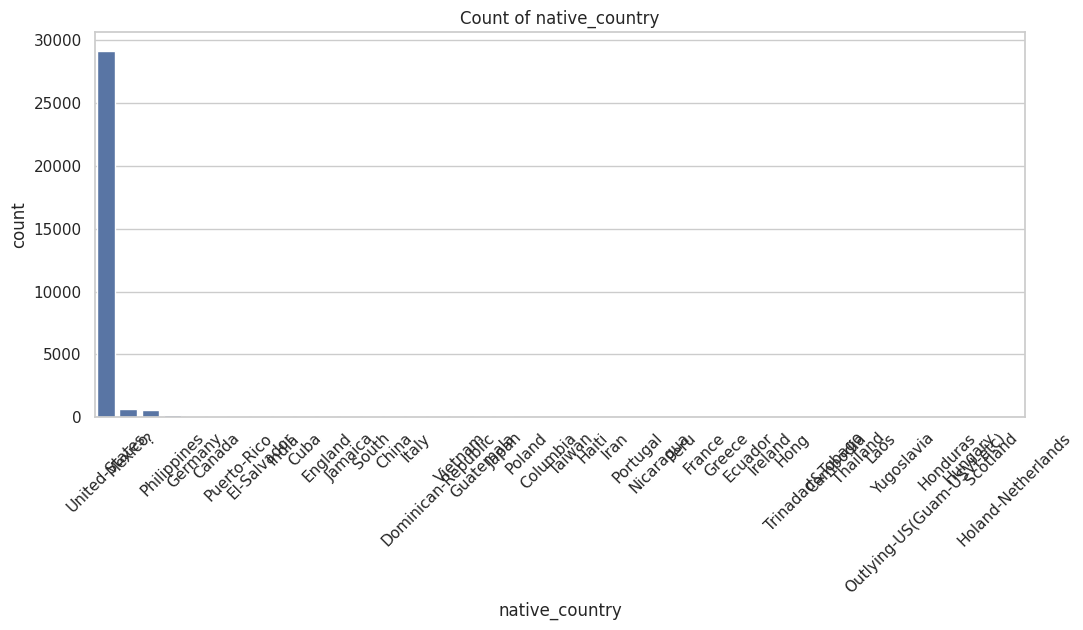

In [18]:
categorical = ['workclass', 'education', 'marital_status', 'occupation',
               'relationship', 'race', 'sex', 'native_country']

for col in categorical:
    plt.figure(figsize=(12, 5))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f'Count of {col}')
    plt.show()


### Categorical features vs Income

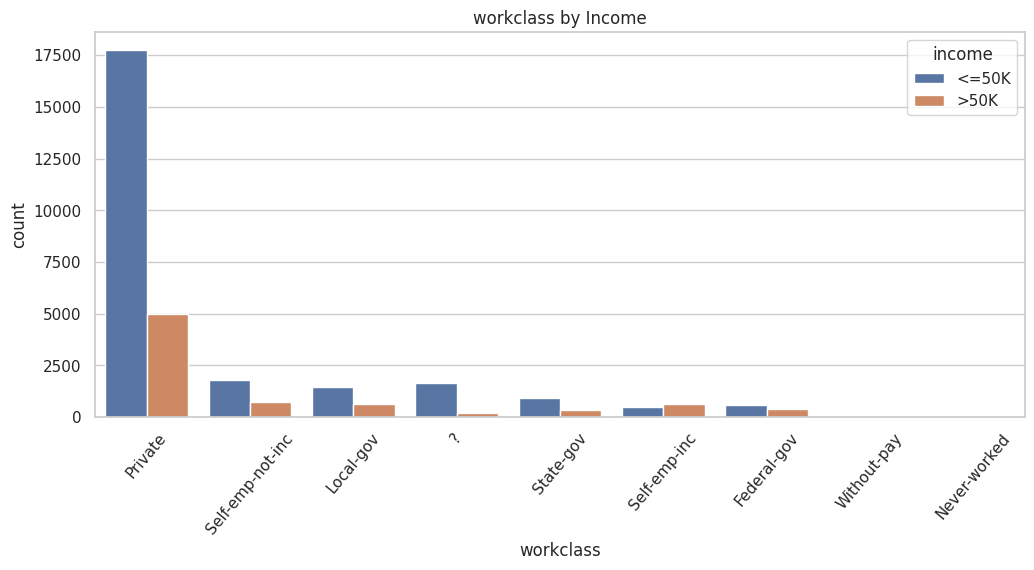

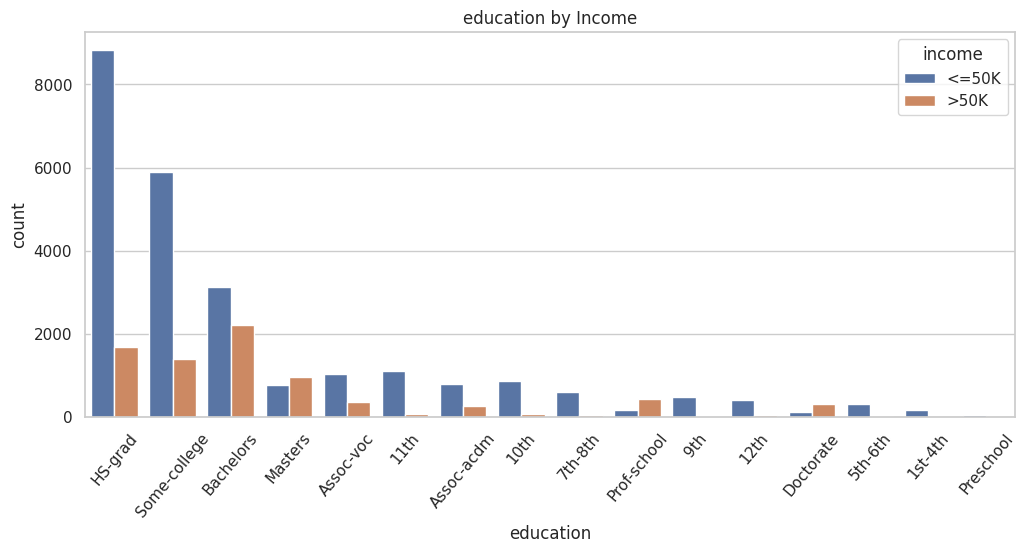

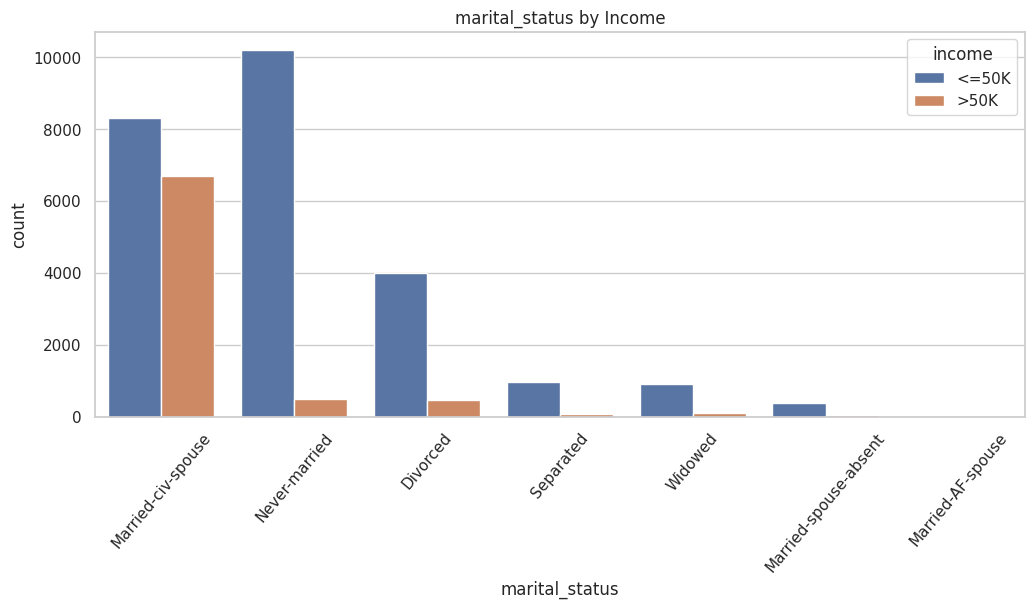

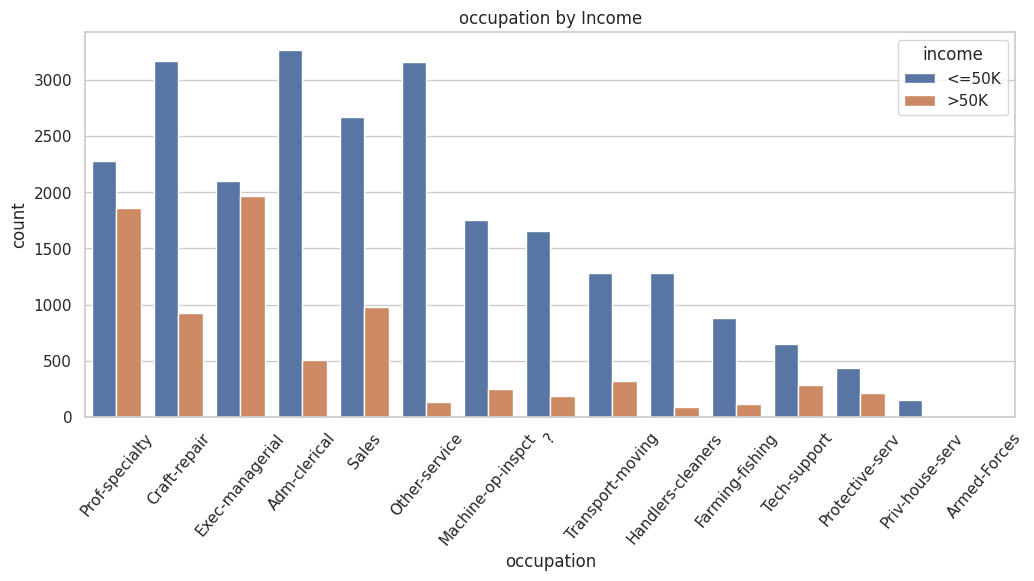

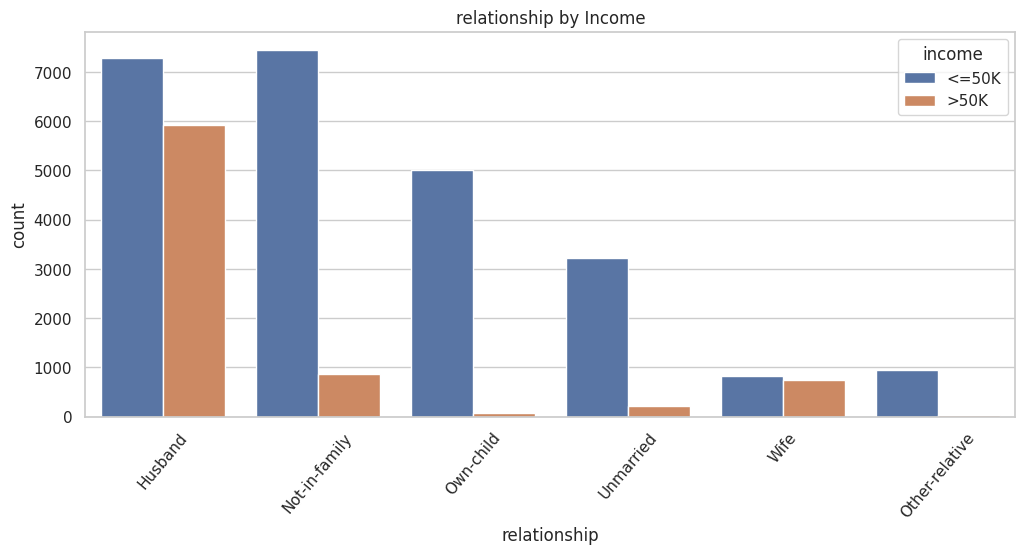

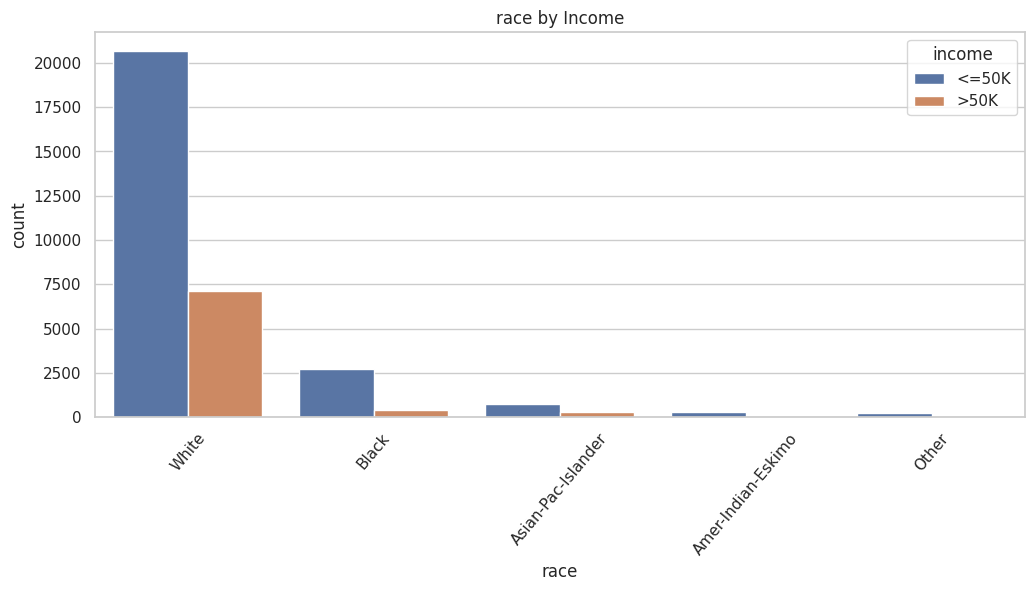

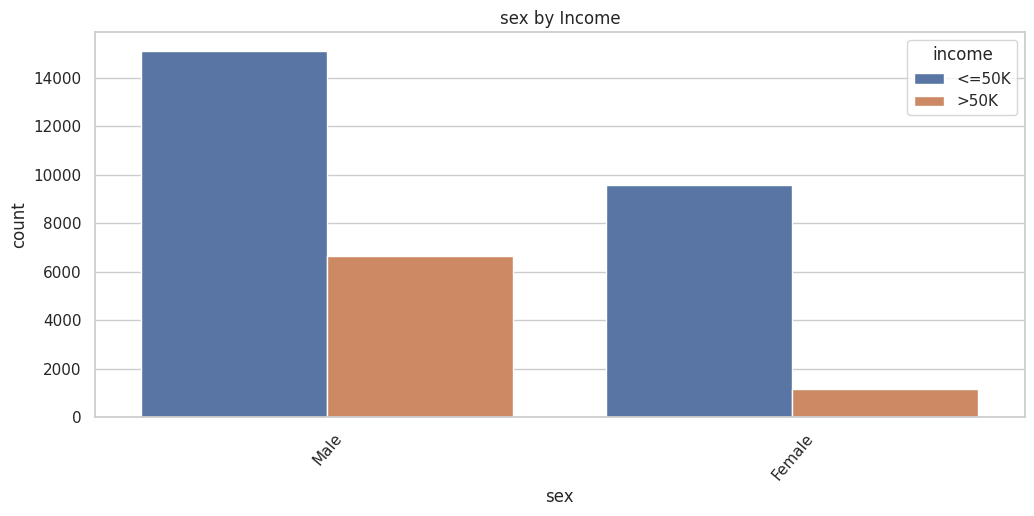

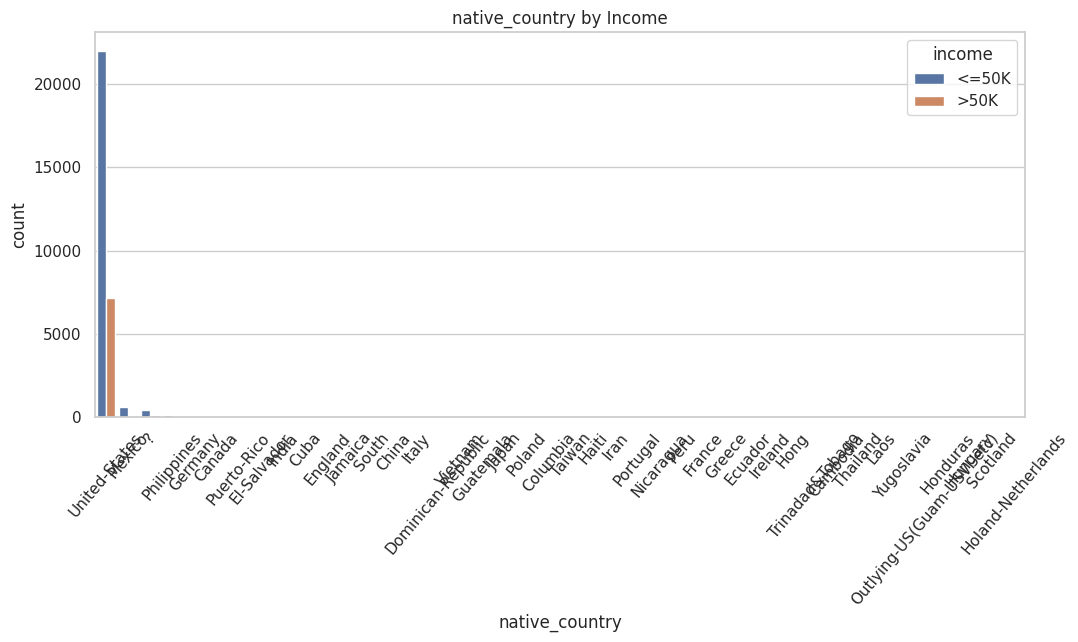

In [19]:
for col in categorical:
    plt.figure(figsize=(12, 5))
    sns.countplot(data=df, x=col, hue='income', order=df[col].value_counts().index)
    plt.xticks(rotation=50)
    plt.title(f'{col} by Income')
    plt.show()

### Average Education Number by Education Level

In [20]:
edu_correlation = df.groupby('education')['education_num'].mean().sort_values()
print(edu_correlation)

education
Preschool        1.0
1st-4th          2.0
5th-6th          3.0
7th-8th          4.0
9th              5.0
10th             6.0
11th             7.0
12th             8.0
HS-grad          9.0
Some-college    10.0
Assoc-voc       11.0
Assoc-acdm      12.0
Bachelors       13.0
Masters         14.0
Prof-school     15.0
Doctorate       16.0
Name: education_num, dtype: float64


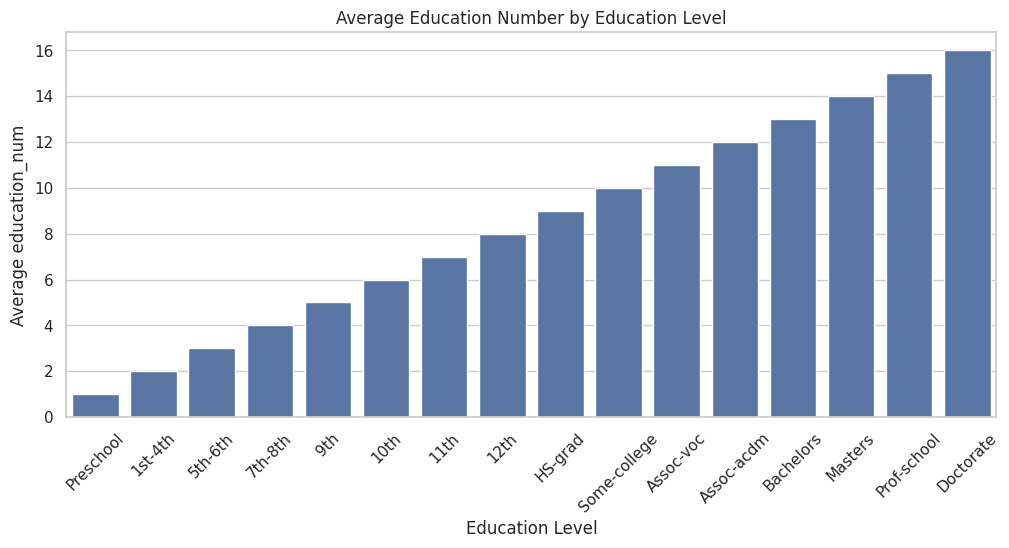

In [21]:
plt.figure(figsize=(12, 5))
sns.barplot(data=df, x='education', y='education_num', order=edu_correlation.index)
plt.xticks(rotation=45)
plt.title('Average Education Number by Education Level')
plt.ylabel('Average education_num')
plt.xlabel('Education Level')
plt.show()


### Race by Occupation

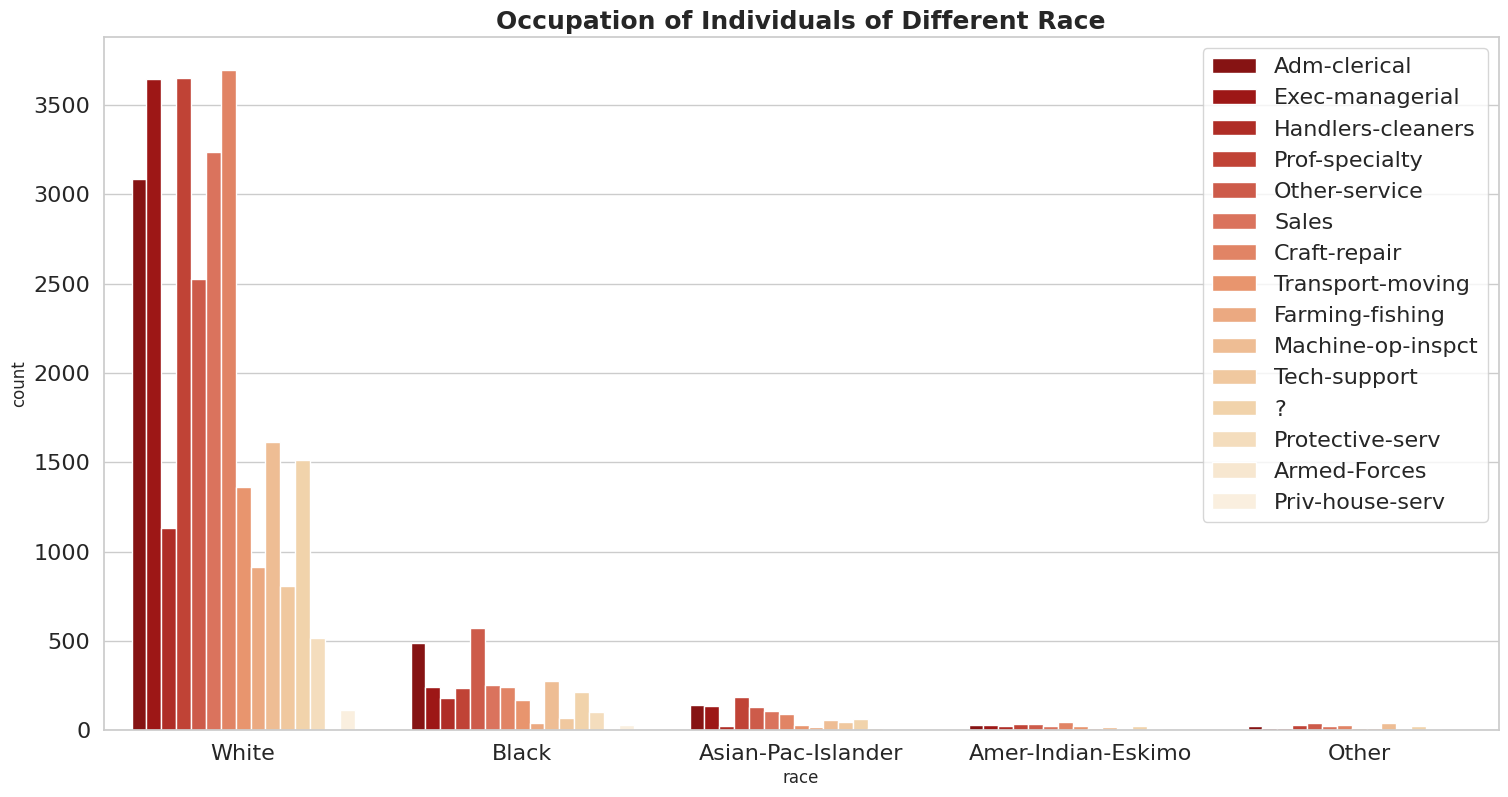

In [22]:
plt.figure(figsize=(18, 9))

# Melt the dataframe to long-form to use 'hue' correctly
df_melted = pd.melt(df, id_vars=['race'], value_vars=['occupation'], var_name='Occupation', value_name='Count')

# Use countplot with melted dataframe and 'hue'
sns.countplot(x='race', hue='Count', data=df_melted, palette='OrRd_r')
plt.title('Occupation of Individuals of Different Race', fontsize=18, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()


### Relationship by age

Are the unmarried people younger or the married people older?



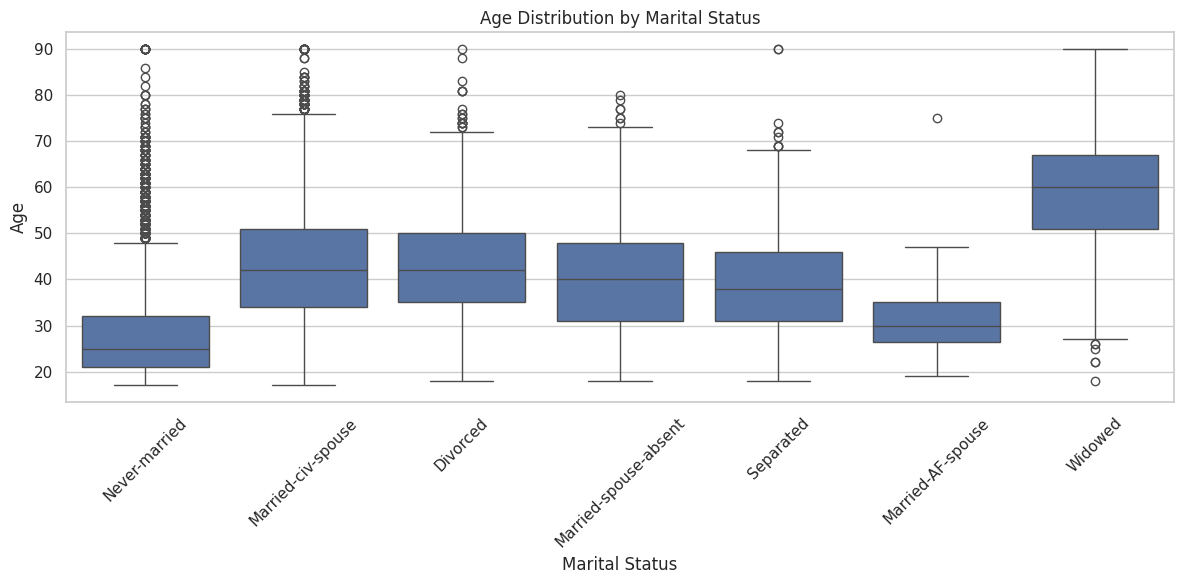

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(x='marital_status', y='age', data=df)
plt.xticks(rotation=45)
plt.title('Age Distribution by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Age')
plt.tight_layout()
plt.show()


### Marital Status Distribution by Age Group

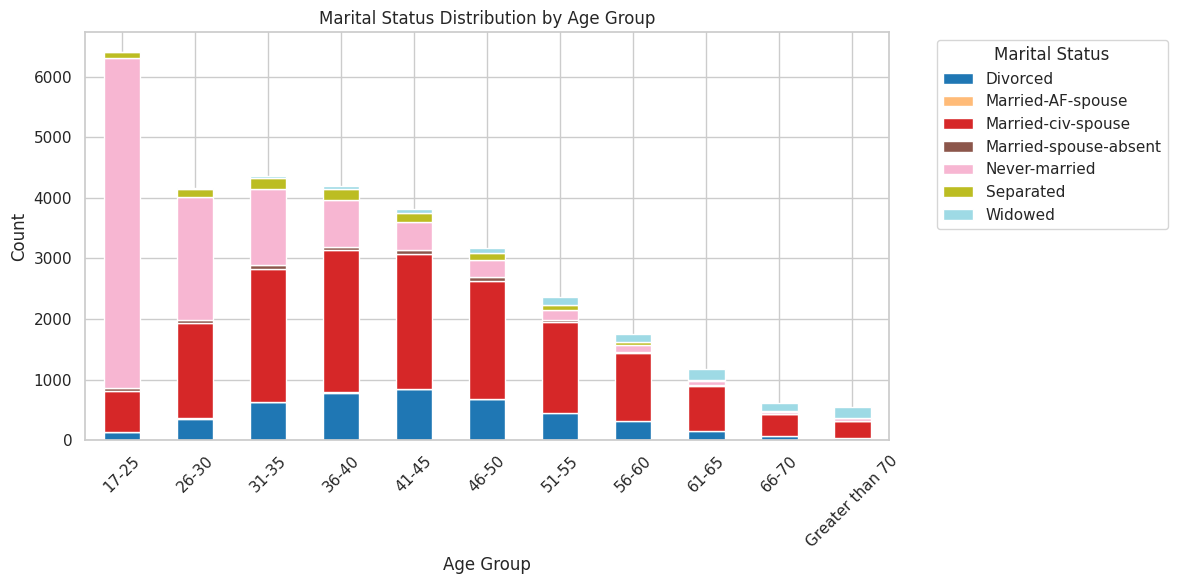

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Create a crosstab of counts
age_marital_counts = pd.crosstab(df['age_group'], df['marital_status'])

# Step 2: Plot as a stacked bar chart
age_marital_counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')

# Step 3: Customize
plt.title('Marital Status Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Marital Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Education Level with Income

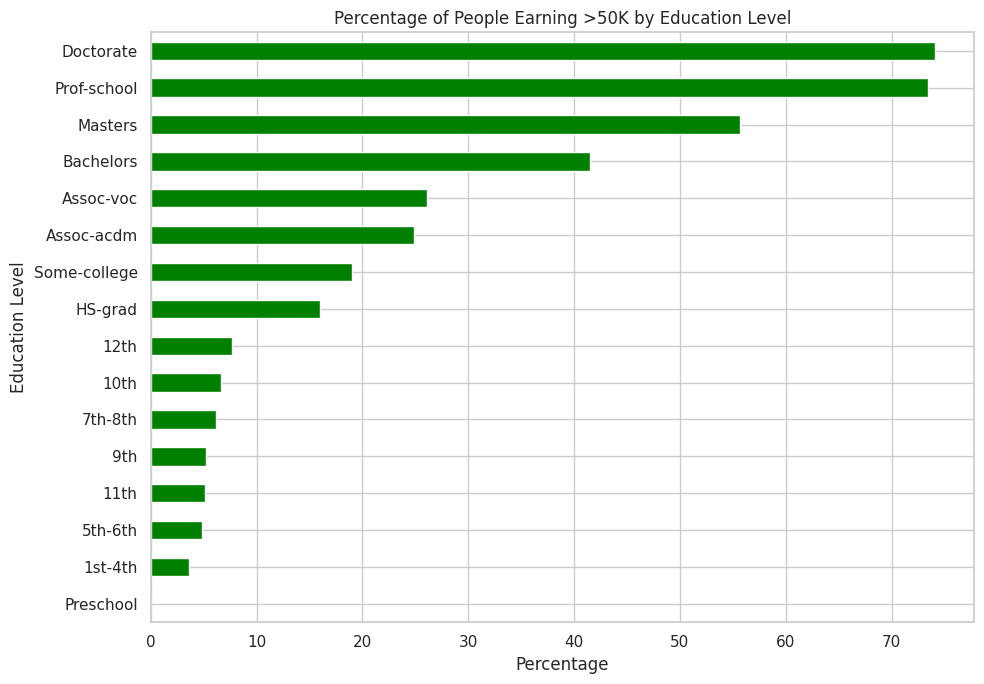

In [25]:
# Create a crosstab of education and income
edu_income = pd.crosstab(df['education'], df['income'], normalize='index') * 100

# Plot percentage of high income for each education level
edu_income['>50K'].sort_values().plot(kind='barh', figsize=(10, 7), color='green')
plt.title('Percentage of People Earning >50K by Education Level')
plt.xlabel('Percentage')
plt.ylabel('Education Level')
plt.tight_layout()
plt.show()


In [26]:
from scipy.stats import chi2_contingency

# Create contingency table
contingency_table = pd.crosstab(df['education'], df['income'])

# Run chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square Statistic = {chi2:.2f}")
print(f"p-value = {p:.4f}")


Chi-square Statistic = 4429.65
p-value = 0.0000


There is a statistically significant association between education level and income.

People with higher education levels (like Bachelor's, Master's, etc.) tend to earn more (more likely to fall in the >50K income group), and this trend is not due to random chance.

### Analyzing Occupation with Education

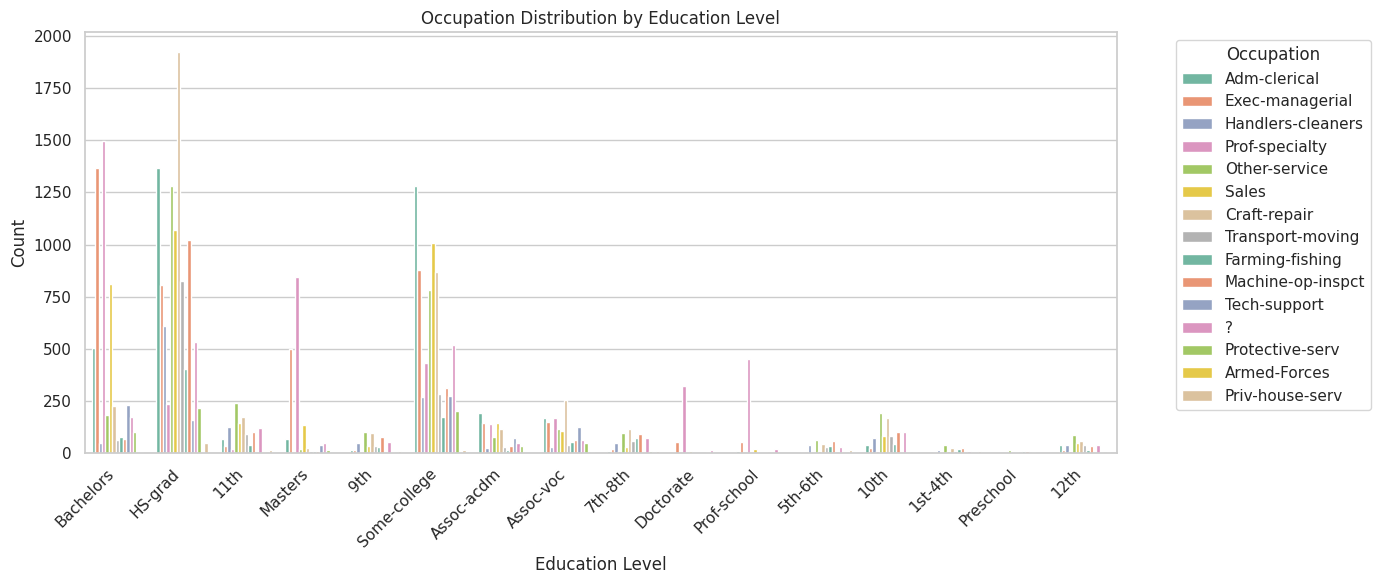

In [27]:
# Grouped bar chart using seaborn
plt.figure(figsize=(14, 6))
sns.countplot(x='education', hue='occupation', data=df, palette='Set2')
plt.title('Occupation Distribution by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Occupation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [28]:
armed_forces_income = df[(df['occupation'] == 'Armed-Forces')]['income'].value_counts()
print("Income Distribution for Armed-Forces:")
print(armed_forces_income)

Income Distribution for Armed-Forces:
income
<=50K    8
>50K     1
Name: count, dtype: int64


In [29]:
armed_forces_income = df[(df['marital_status'] == 'Married-AF-spouse')]['income'].value_counts()
print("Income Distribution With Marital Status:")
print(armed_forces_income)

Income Distribution With Marital Status:
income
<=50K    13
>50K     10
Name: count, dtype: int64


### Percentage distribution of different Races

In [30]:
race_distribution = df['race'].value_counts()
print(race_distribution)
race_percentage = (race_distribution / len(df)) * 100
print(race_percentage)

race
White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: count, dtype: int64
race
White                 85.427352
Black                  9.594300
Asian-Pac-Islander     3.190934
Amer-Indian-Eskimo     0.955130
Other                  0.832284
Name: count, dtype: float64


### Education VS Occupation.

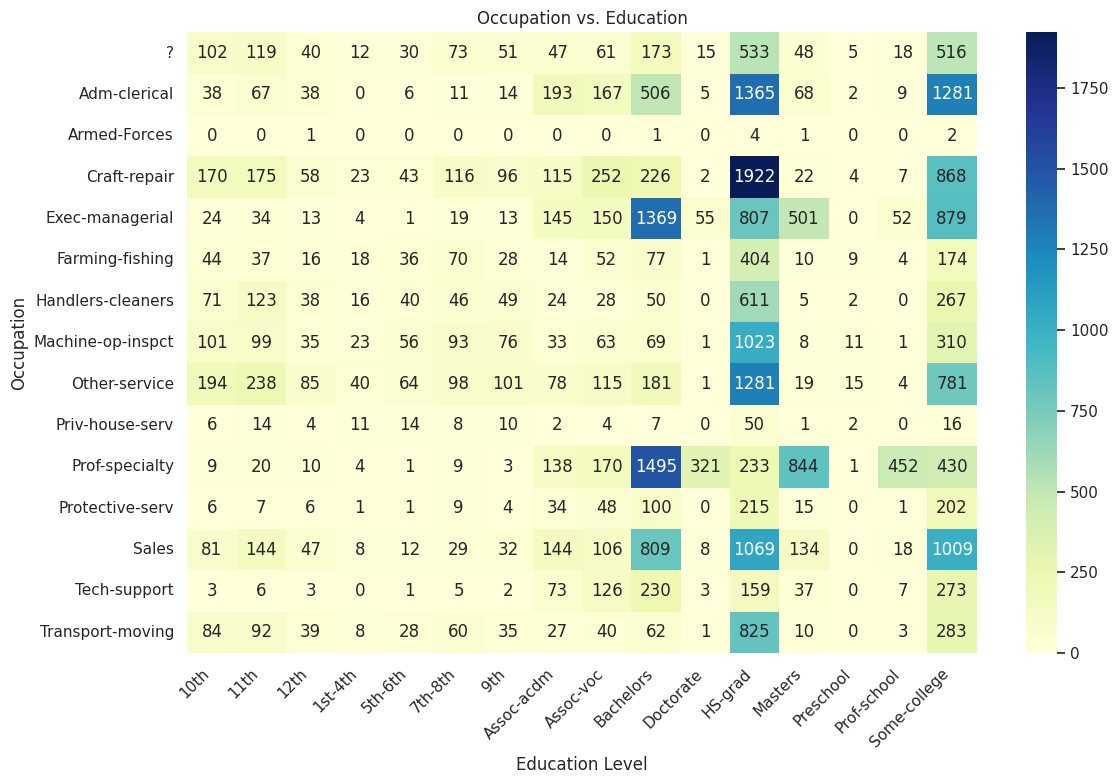

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

   # Create a crosstab of occupation and education
occupation_education = pd.crosstab(df['occupation'], df['education'])

   # Visualize using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(occupation_education, annot=True, cmap="YlGnBu", fmt="d")
plt.title('Occupation vs. Education')
plt.xlabel('Education Level')
plt.ylabel('Occupation')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.tight_layout()
plt.savefig('occupation_education.png')  # Save as PNG
plt.show()
from google.colab import files
files.download('occupation_education.png')

In [32]:
from scipy.stats import chi2_contingency

# Create contingency table
contingency_table = pd.crosstab(df['occupation'], df['education'])
#Run chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square Statistic = {chi2:.2f}")
print(f"p-value = {p:.4f}")

Chi-square Statistic = 15997.78
p-value = 0.0000


There is a significant association between occupation and education in your dataset.

In other words, a person’s education level and their occupation are not independent of each other.

### Analyzing average income (as a proportion) for each workclass

In [33]:
# Create a numerical income column
df['income_numerical'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

# Calculate average income for each workclass
average_income_by_workclass = df.groupby('workclass')['income_numerical'].mean()

# Print the results
print(average_income_by_workclass)

workclass
?                   0.104031
Federal-gov         0.386458
Local-gov           0.294792
Never-worked        0.000000
Private             0.218673
Self-emp-inc        0.557348
Self-emp-not-inc    0.284927
State-gov           0.271957
Without-pay         0.000000
Name: income_numerical, dtype: float64


### Education vs Workclass

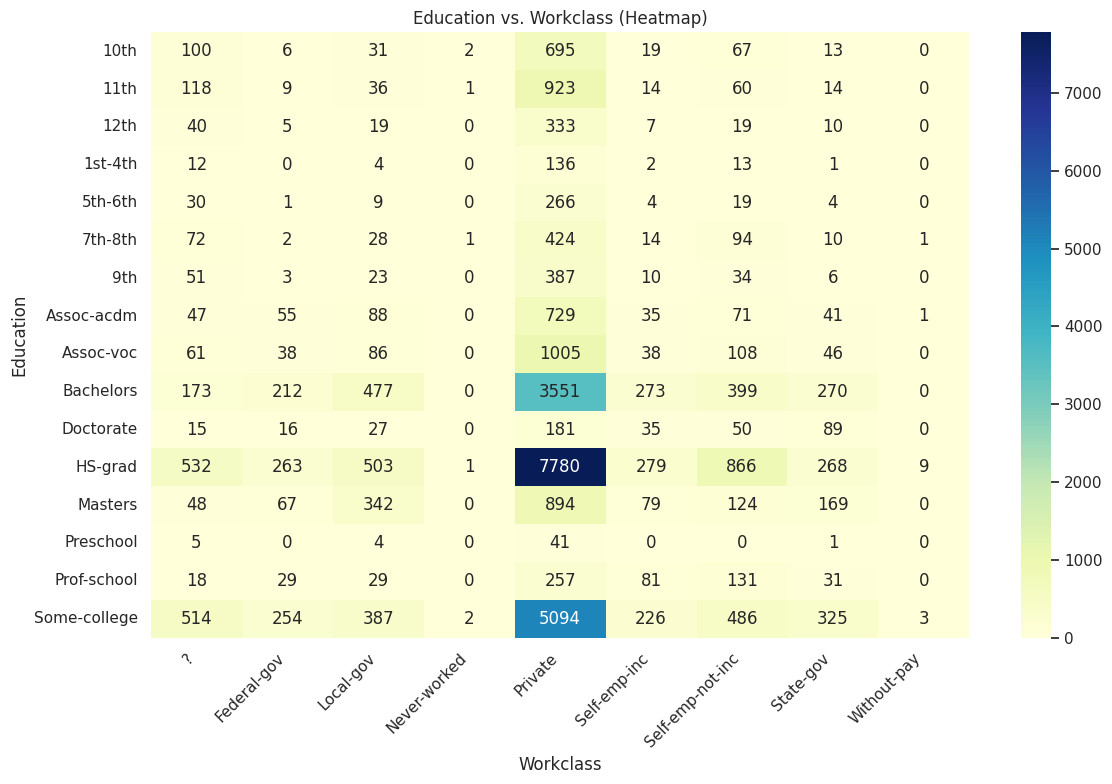

In [34]:
education_workclass = pd.crosstab(df['education'], df['workclass'])

plt.figure(figsize=(12, 8))
sns.heatmap(education_workclass, annot=True, cmap="YlGnBu", fmt="d")
plt.title('Education vs. Workclass (Heatmap)')
plt.xlabel('Workclass')
plt.ylabel('Education')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Workclass with occupation

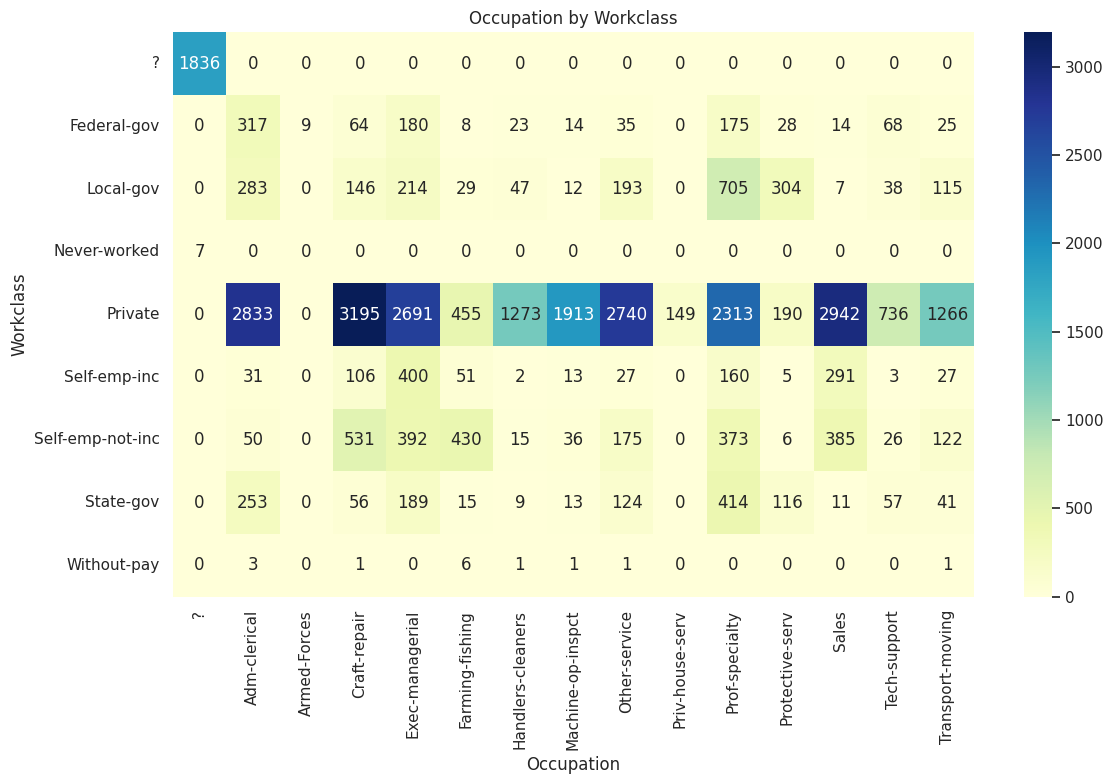

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(pd.crosstab(df['workclass'], df['occupation']), cmap="YlGnBu", annot=True, fmt='d')
plt.title("Occupation by Workclass")
plt.ylabel("Workclass")
plt.xlabel("Occupation")
plt.tight_layout()
plt.show()


In [36]:
pd.crosstab(df['workclass'], df['occupation'])


occupation           ?  Adm-clerical  Armed-Forces  Craft-repair  \
workclass                                                          
?                 1836             0             0             0   
Federal-gov          0           317             9            64   
Local-gov            0           283             0           146   
Never-worked         7             0             0             0   
Private              0          2833             0          3195   
Self-emp-inc         0            31             0           106   
Self-emp-not-inc     0            50             0           531   
State-gov            0           253             0            56   
Without-pay          0             3             0             1   

occupation        Exec-managerial  Farming-fishing  Handlers-cleaners  \
workclass                                                               
?                               0                0                  0   
Federal-gov                   180                8                 23   
Local-gov                     214               29                 47   
Never-worked                    0                0                  0   
Private                      2691              455               1273   
Self-emp-inc                  400               51                  2   
Self-emp-not-inc              392              430                 15   
State-gov                     189               15                  9   
Without-pay                     0                6                  1   

occupation        Machine-op-inspct  Other-service  Priv-house-serv  \
workclass                                                             
?                                 0              0                0   
Federal-gov                      14             35                0   
Local-gov                        12            193                0   
Never-worked                      0              0                0   
Private                        1913           2740              149   
Self-emp-inc                     13             27                0   
Self-emp-not-inc                 36            175                0   
State-gov                        13            124                0   
Without-pay                       1              1                0   

occupation        Prof-specialty  Protective-serv  Sales  Tech-support  \
workclass                                                                
?                              0                0      0             0   
Federal-gov                  175               28     14            68   
Local-gov                    705              304      7            38   
Never-worked                   0                0      0             0   
Private                     2313              190   2942           736   
Self-emp-inc                 160                5    291             3   
Self-emp-not-inc             373                6    385            26   
State-gov                    414              116     11            57   
Without-pay                    0                0      0             0   

occupation        Transport-moving  
workclass                           
?                                0  
Federal-gov                     25  
Local-gov                      115  
Never-worked                     0  
Private                       1266  
Self-emp-inc                    27  
Self-emp-not-inc               122  
State-gov                       41  
Without-pay                      1

### Income Distribution by WorkClass

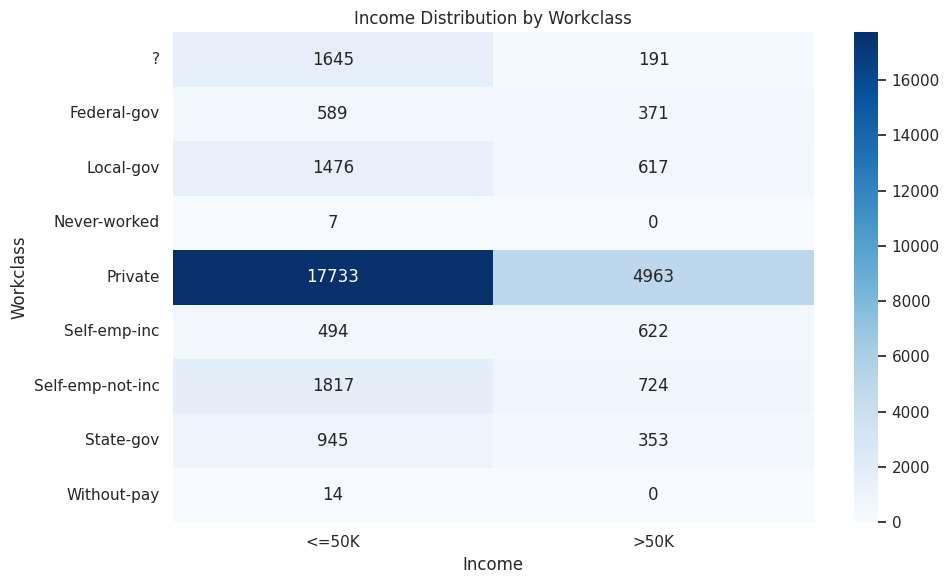

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(df['workclass'], df['income']), annot=True, fmt='d',cmap='Blues')
plt.title("Income Distribution by Workclass")
plt.ylabel("Workclass")
plt.xlabel("Income")
plt.tight_layout()
plt.show()

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import time
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import sys
sys.path.append('/content/drive/MyDrive/MLProject/automated_selection.py')

In [41]:
!cp /content/drive/MyDrive/MLProject/automated_selection.py .

In [42]:
column_names = [
    "age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
    "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
    "hours_per_week", "native_country", "income"
]

# Read the dataset with the correct column names
df = pd.read_csv("/content/drive/MyDrive/MLProject/census_income/adult.data", names=column_names, sep=",", skipinitialspace=True)

# Display the first few rows
df.head(5)

age         workclass  fnlwgt  education  education_num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital_status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital_gain  capital_loss  hours_per_week native_country income  
0          2174             0              40  United-States  <=50K  
1             0             0              13  United-States  <=50K  
2             0             0              40  United-States  <=50K  
3             0             0              40  United-States  <=50K  
4             0             0              40           Cuba  <=50K

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [44]:
# Step 1: Handle Missing Values by replacing '?' with NaN
df.replace('?', np.nan, inplace=True)
print("\nStep 1: Replaced '?' with NaN.")
print("Check for NaNs after replacement:")
print(df.isnull().sum())
print("\nCheck dtypes after replacement:")
print(df.info())


Step 1: Replaced '?' with NaN.
Check for NaNs after replacement:
age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
income               0
dtype: int64

Check dtypes after replacement:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  o

Drop irrelevant

In [45]:
df.drop(['education', 'capital_loss', 'capital_gain', 'native_country','occupation', 'fnlwgt'], axis=1, inplace=True)

# **Pipeline**

In [46]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

# Step 1: Define X and y
X = df.iloc[:, :-1]
y = df.iloc[:, -1]   # Assuming 'income' is the last column

# Step 2: Identify feature types
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Step 3: Build transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Step 4: Combine transformers
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Step 5: Encode target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 6: Full preprocessing pipeline (no model yet)
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor)
])


## **Transform the Data (with Column Names)**

comfirming if our results worked

In [47]:
# Fit and transform X
X_transformed = pipeline.fit_transform(X)

# Get the feature names after one-hot encoding
onehot_feature_names = pipeline.named_steps['preprocessing']\
    .named_transformers_['cat']\
    .named_steps['encoder']\
    .get_feature_names_out(categorical_cols)

# Combine numeric and one-hot names
feature_names = numerical_cols + list(onehot_feature_names)

# Rebuild X_transformed as DataFrame with proper column names
X_ready = pd.DataFrame(X_transformed.toarray() if hasattr(X_transformed, "toarray") else X_transformed,
                       columns=feature_names)

# New Section

In [48]:
X_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   32561 non-null  float64
 1   education_num                         32561 non-null  float64
 2   hours_per_week                        32561 non-null  float64
 3   workclass_Federal-gov                 32561 non-null  float64
 4   workclass_Local-gov                   32561 non-null  float64
 5   workclass_Never-worked                32561 non-null  float64
 6   workclass_Private                     32561 non-null  float64
 7   workclass_Self-emp-inc                32561 non-null  float64
 8   workclass_Self-emp-not-inc            32561 non-null  float64
 9   workclass_State-gov                   32561 non-null  float64
 10  workclass_Without-pay                 32561 non-null  float64
 11  marital_status_

In [49]:
y

0        <=50K
1        <=50K
2        <=50K
3        <=50K
4        <=50K
         ...  
32556    <=50K
32557     >50K
32558    <=50K
32559    <=50K
32560     >50K
Name: income, Length: 32561, dtype: object

# **Class Balance on original data**

In [50]:
## Get counts of classes
print(f"Intial no. of instances : {len (y_encoded)}")
print(f"No. of zero class intances (majority) : {sum (y_encoded==0)}")
print(f"No. of one class instances (minority) : {sum(y_encoded==1) }")

Intial no. of instances : 32561
No. of zero class intances (majority) : 24720
No. of one class instances (minority) : 7841


In [51]:
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler ()
X_new, y_new = oversampler.fit_resample(X, y_encoded)
print(f"Oversampled no. of instances : {len (y_new) }")
print(f"No. of zero class intances : {sum(y_new==0)}")
print(f"No. of one class instances: {sum(y_new==1)}")

Oversampled no. of instances : 49440
No. of zero class intances : 24720
No. of one class instances: 24720


In [52]:
# Step 7: Train-test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

# Step 8: Apply preprocessing
X_train = pipeline.fit_transform(X_train_raw)
X_test = pipeline.transform(X_test_raw)

# Convert to dense numpy arrays
X_train = X_train.toarray() if hasattr(X_train, "toarray") else X_train
X_test = X_test.toarray() if hasattr(X_test, "toarray") else X_test

# **Feature Selection**

# New Section

Using Lasso for feature selection

# **Dimensionality Reduction**

# Using LDA

In [53]:
# Step 9: Apply LDA
# For binary classification, LDA reduces to 1 component
lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

# Step 10: Train and evaluate a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_lda, y_train)
y_pred = clf.predict(X_test_lda)

In [54]:
# Step 11: Report
print("Classification Report (LDA reduced):")
print(classification_report(y_test, y_pred))


Classification Report (LDA reduced):
              precision    recall  f1-score   support

           0       0.93      0.77      0.84      4938
           1       0.81      0.94      0.87      4950

    accuracy                           0.86      9888
   macro avg       0.87      0.86      0.86      9888
weighted avg       0.87      0.86      0.86      9888



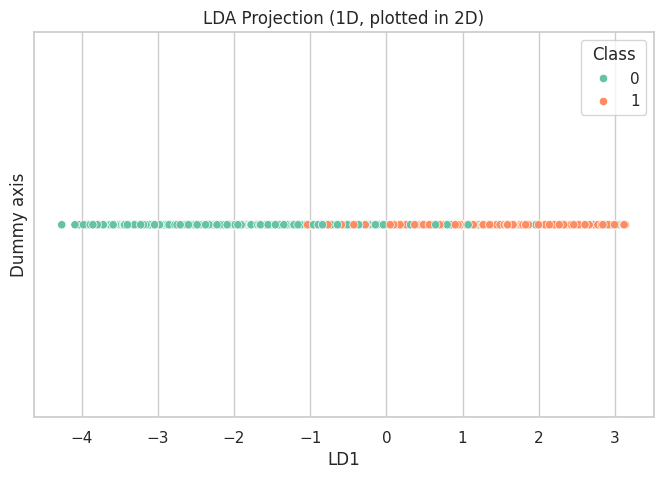

In [55]:
X_train_lda_2D = np.hstack([X_train_lda, np.zeros_like(X_train_lda)])

plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_train_lda_2D[:, 0], y=X_train_lda_2D[:, 1], hue=y_train, palette='Set2')
plt.title("LDA Projection (1D, plotted in 2D)")
plt.xlabel("LD1")
plt.ylabel("Dummy axis")
plt.yticks([])
plt.legend(title="Class")
plt.show()



## KNN

In [56]:
knn = KNeighborsClassifier()
knn.fit(X_train_lda, y_train)
y_pred_knn_lda = knn.predict(X_test_lda)


In [57]:
# Step 11: Report
print("Classification Report KNN (LDA reduced):")
print(classification_report(y_test, y_pred_knn_lda))

Classification Report KNN (LDA reduced):
              precision    recall  f1-score   support

           0       0.87      0.72      0.79      4938
           1       0.76      0.89      0.82      4950

    accuracy                           0.81      9888
   macro avg       0.82      0.81      0.81      9888
weighted avg       0.82      0.81      0.81      9888



## Decision Tree

In [58]:
dt_lda = DecisionTreeClassifier()
dt_lda.fit(X_train_lda, y_train)
y_pred_dt_lda = knn.predict(X_test_lda)


In [59]:
# Step 11: Report
print("Classification Report Decision Tree(LDA reduced):")
print(classification_report(y_test, y_pred_dt_lda))

Classification Report Decision Tree(LDA reduced):
              precision    recall  f1-score   support

           0       0.87      0.72      0.79      4938
           1       0.76      0.89      0.82      4950

    accuracy                           0.81      9888
   macro avg       0.82      0.81      0.81      9888
weighted avg       0.82      0.81      0.81      9888



## Logistic Regression

In [60]:
# Fitting Logistic Regression to df Set
from sklearn. linear_model import LogisticRegression
model_lr_lda = LogisticRegression()
model_lr_lda.fit(X_train_lda, y_train)
y_pred_lr_lda = model_lr_lda.predict(X_test_lda)

# Step 11: Report
print("Classification Report Logistic Regression (LDA reduced):")
print(classification_report(y_test, y_pred_lr_lda))

Classification Report Logistic Regression (LDA reduced):
              precision    recall  f1-score   support

           0       0.84      0.73      0.78      4938
           1       0.76      0.86      0.81      4950

    accuracy                           0.79      9888
   macro avg       0.80      0.79      0.79      9888
weighted avg       0.80      0.79      0.79      9888



## Random Forest

In [61]:
model_rf_lda = RandomForestClassifier()
model_rf_lda.fit(X_train_lda, y_train)
y_pred_rf_lda = model_rf_lda.predict(X_test_lda)

# Step 11: Report
print("Classification Report Logistic Regression (LDA reduced):")
print(classification_report(y_test, y_pred_rf_lda))

Classification Report Logistic Regression (LDA reduced):
              precision    recall  f1-score   support

           0       0.93      0.78      0.85      4938
           1       0.81      0.94      0.87      4950

    accuracy                           0.86      9888
   macro avg       0.87      0.86      0.86      9888
weighted avg       0.87      0.86      0.86      9888



# PCA

In [62]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

## KNN

In [63]:
knn_pca = KNeighborsClassifier()
knn_pca.fit(X_train_pca, y_train)
y_pred_knn_pca = knn_pca.predict(X_test_pca)




print("Classification Report KNN (PCA reduced):")
print(classification_report(y_test, y_pred_knn_pca))

Classification Report KNN (PCA reduced):
              precision    recall  f1-score   support

           0       0.85      0.71      0.78      4938
           1       0.75      0.88      0.81      4950

    accuracy                           0.80      9888
   macro avg       0.80      0.80      0.79      9888
weighted avg       0.80      0.80      0.79      9888



## Decision Tree

In [64]:
dt_pca = DecisionTreeClassifier()
dt_pca.fit(X_train_pca, y_train)
y_pred_dt_pca = dt_pca.predict(X_test_pca)


print("Classification Report Decision Tree(PCA reduced):")
print(classification_report(y_test, y_pred_dt_pca))

Classification Report Decision Tree(PCA reduced):
              precision    recall  f1-score   support

           0       0.91      0.77      0.84      4938
           1       0.80      0.93      0.86      4950

    accuracy                           0.85      9888
   macro avg       0.86      0.85      0.85      9888
weighted avg       0.86      0.85      0.85      9888



## Logistic Regression

In [65]:
from sklearn. linear_model import LogisticRegression
lr_pca = LogisticRegression()
lr_pca.fit(X_train_pca, y_train)
y_pred_lr_pca = lr_pca.predict(X_test_pca)


print("Classification Report Logistic Regression (PCA reduced):")
print(classification_report(y_test, y_pred_lr_pca))

Classification Report Logistic Regression (PCA reduced):
              precision    recall  f1-score   support

           0       0.79      0.75      0.77      4938
           1       0.76      0.81      0.78      4950

    accuracy                           0.78      9888
   macro avg       0.78      0.78      0.78      9888
weighted avg       0.78      0.78      0.78      9888



## Random Forest

In [66]:
rf_pca = RandomForestClassifier()
rf_pca.fit(X_train_pca, y_train)
y_pred_rf_pca = rf_pca.predict(X_test_pca)


print("Classification Report Logistic Regression (PCA reduced):")
print(classification_report(y_test, y_pred_rf_pca))

Classification Report Logistic Regression (PCA reduced):
              precision    recall  f1-score   support

           0       0.93      0.77      0.85      4938
           1       0.81      0.94      0.87      4950

    accuracy                           0.86      9888
   macro avg       0.87      0.86      0.86      9888
weighted avg       0.87      0.86      0.86      9888



## XGBoost

In [67]:
bst_pca = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
bst_pca.fit(X_train_pca, y_train)
y_pred_bst_pca = bst_pca.predict(X_test_pca)

print("Classification Report XGBoost(PCA reduced):")
print(classification_report(y_test, y_pred_bst_pca))

Classification Report XGBoost(PCA reduced):
              precision    recall  f1-score   support

           0       0.82      0.73      0.77      4938
           1       0.75      0.84      0.79      4950

    accuracy                           0.78      9888
   macro avg       0.79      0.78      0.78      9888
weighted avg       0.79      0.78      0.78      9888



# PCA Kernel

In [ ]:
from sklearn.decomposition import KernelPCA

kernel_pca = KernelPCA(n_components=2, kernel='rbf')
X_train_kernel_pca = kernel_pca.fit_transform(X_train)
X_test_kernel_pca = kernel_pca.transform (X_test)

## KNN - PCA Kernel

In [1]:
# kernel_pca = KNeighborsClassifier()
# kernel_pca.fit(X_train_kernel_pca, y_train)
# y_pred_knn_kernel_pca = kernel_pca.predict(X_test_kernel_pca)


# # Step 11: Report
# print("Classification Report KNN (Kernel PCA reduced):")
# print(classification_report(y_test, y_pred_knn_kernel_pca))

## Decision Tree - PCA Kernel

In [ ]:
dt_kernel_pca = DecisionTreeClassifier()
dt_kernel_pca.fit(X_train_kernel_pca, y_train)
y_pred_kernel_pca = kernel_pca.predict(X_test_kernel_pca)


print("Classification Report Decision Tree (Kernal PCA reduced):")
print(classification_report(y_test, y_pred_dt_kernel_pca))

 ## Logistic Regression - PCA Kernel

In [ ]:
# from sklearn.linear_model import LogisticRegression
# lr_kernel_pca = LogisticRegression()
# lr_kernel_pca.fit(X_train_kernel_pca, y_train)
# y_pred_kernel_pca= lr_kernel_pca.predict(X_test_kernel_pca)

# # Step 11: Report
# print("Classification Report Logistic Regression (Kernal PCA reduced):")
# print(classification_report(y_test, y_pred_kernel_pca))

## Random Forest - PCA Kernel

In [2]:
# rf_kernel_pca = RandomForestClassifier()
# rf_kernel_pca.fit(X_train, y_train)
# y_pred_rf_kernel_pca = rf_kernel_pca.predict(X_test)

# # Step 11: Report
# print("Classification Report Random Forest (Kernal PCA reduced):")
# print(classification_report(y_test, y_pred_rf_kernel_pca))

# **FUll Model training**

## Logistic Regression

In [72]:
# Fitting Logistic Regression to df Set
from sklearn. linear_model import LogisticRegression
model_lr2 = LogisticRegression()
model_lr2.fit(X_train, y_train)

# Making predictions on the Test Set
y_hat_lr2 = model_lr2.predict(X_test)
# Predicting probabilities
y_hat_prob_lr2 = model_lr2.predict_proba(X_test)


              precision    recall  f1-score   support

           0       0.84      0.74      0.79      4938
           1       0.77      0.86      0.81      4950

    accuracy                           0.80      9888
   macro avg       0.81      0.80      0.80      9888
weighted avg       0.81      0.80      0.80      9888



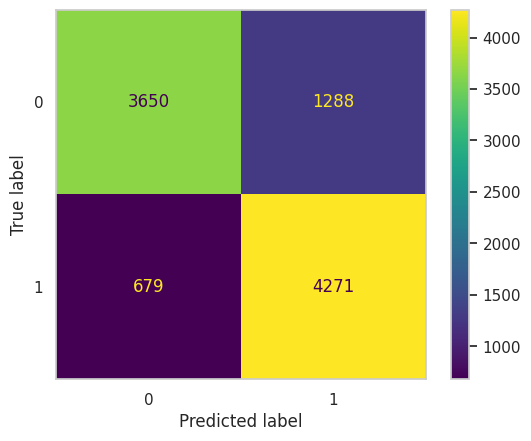

In [73]:
print(classification_report(y_test, y_hat_lr2))

cm = confusion_matrix(y_test, y_hat_lr2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(visible=False)
plt.show()


## KNN

In [74]:
# 1. Train KNN with best hyperparameters
knn2 = KNeighborsClassifier(n_neighbors=9, weights='distance', metric='manhattan')
knn2.fit(X_train, y_train)

# 2. Make predictions
y_predknn = knn2.predict(X_test)
y_proba = knn2.predict_proba(X_test)[:, 1]  # For ROC curve


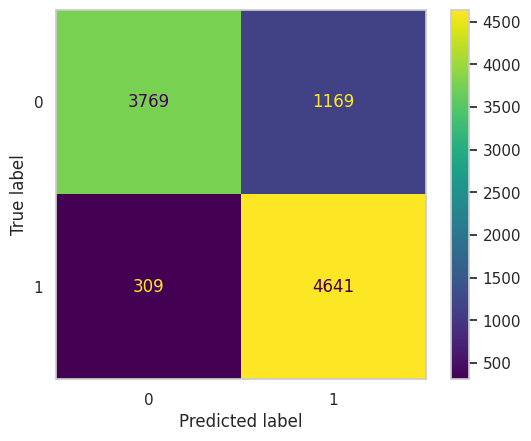

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.76      0.84      4938
           1       0.80      0.94      0.86      4950

    accuracy                           0.85      9888
   macro avg       0.86      0.85      0.85      9888
weighted avg       0.86      0.85      0.85      9888



In [75]:
# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_predknn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(visible=False)
plt.show()

# 4. Classification Report
report = classification_report(y_test, y_predknn)
print("Classification Report:")
print(report)



## Decision Tree

In [76]:
RANDOM_SEED=42
from sklearn.tree import DecisionTreeClassifier
model_dt = DecisionTreeClassifier(random_state=RANDOM_SEED)
model_dt.fit(X_train, y_train)

y_hat_dt = model_dt.predict(X_test)

              precision    recall  f1-score   support

           0       0.92      0.78      0.85      4938
           1       0.81      0.93      0.87      4950

    accuracy                           0.86      9888
   macro avg       0.87      0.86      0.86      9888
weighted avg       0.87      0.86      0.86      9888



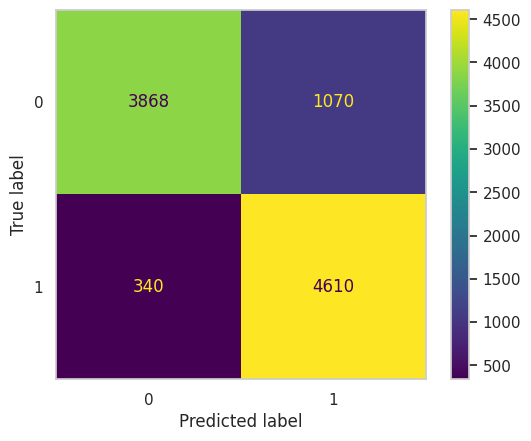

In [77]:
# Use model
print(classification_report(y_test, y_hat_dt))
cm = confusion_matrix(y_test, y_hat_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(visible=False)
plt.show()


## XGBoost

In [78]:
# Initialize XGBoost classifier with tuned hyperparameters
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=341,
    learning_rate=np.float64(0.28323850914860726),
    max_depth=8,
    subsample=np.float64(0.5079831261101071),
    colsample_bytree=np.float64(0.7252496259847715),
    gamma=np.float64(0.06632480579933264),
    reg_lambda=np.float64(3.854165025399161),
    random_state=42
)

# Train the model
xgb_clf.fit(X_train, y_train)

# Predict on test set
y_predXG = xgb_clf.predict(X_test)


              precision    recall  f1-score   support

           0       0.90      0.78      0.84      4938
           1       0.81      0.92      0.86      4950

    accuracy                           0.85      9888
   macro avg       0.86      0.85      0.85      9888
weighted avg       0.86      0.85      0.85      9888



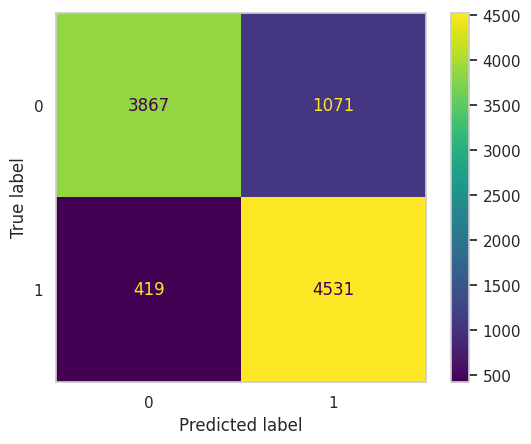

In [79]:
print(classification_report(y_test, y_predXG))

cm = confusion_matrix(y_test, y_predXG)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(visible=False)
plt.show()


## Random Forest

In [80]:
from sklearn.ensemble import RandomForestClassifier
# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_classifier.predict(X_test)

              precision    recall  f1-score   support

           0       0.93      0.79      0.86      4938
           1       0.82      0.94      0.88      4950

    accuracy                           0.87      9888
   macro avg       0.88      0.87      0.87      9888
weighted avg       0.88      0.87      0.87      9888



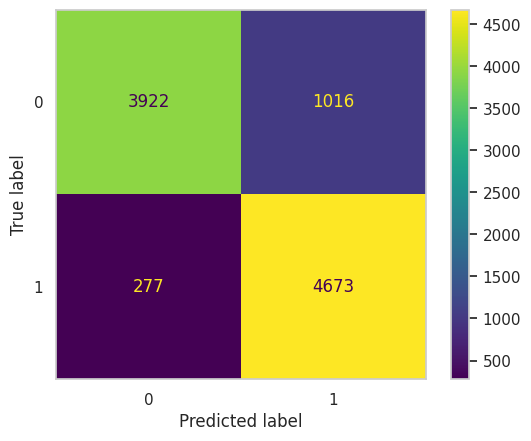

In [81]:
print(classification_report(y_test,y_pred_rf))

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(visible=False)
plt.show()


Backward Elimation

In [82]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from automated_selection import backward_elimination
# Example usage

# if you see ERROR ModuleNotFoundError: No module named 'automated_selection'
# That means you do not have automated_selection.py in you folder
X_sig, selected_features, eliminated_features = backward_elimination(X_train, y_train, significance_level=0.05)
obj_OLS = sm. OLS(endog=y_train, exog=X_sig). fit()
print (obj_OLS.summary ())
print ("Selected features:", selected_features)
print("Eliminated features:", eliminated_features)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     1435.
Date:                Wed, 14 May 2025   Prob (F-statistic):               0.00
Time:                        23:23:00   Log-Likelihood:                -17910.
No. Observations:               39552   AIC:                         3.586e+04
Df Residuals:                   39531   BIC:                         3.604e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0564      0.002     24.324      0.0

In [83]:
# Map: 'x0' → actual column name from X_ready
index_to_col = {f'x{i}': col for i, col in enumerate(X_ready.columns)}


In [84]:
# Convert x-names to actual names
selected_real_names = [index_to_col[x] for x in selected_features if x in index_to_col]
eliminated_real_names = [index_to_col[x] for x in eliminated_features if x in index_to_col]

print(len(selected_real_names)," Selected features:", selected_real_names)
print(len(eliminated_real_names), " Eliminated features:", eliminated_real_names)


21  Selected features: ['age', 'education_num', 'hours_per_week', 'workclass_Federal-gov', 'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc', 'workclass_State-gov', 'workclass_Without-pay', 'marital_status_Married-AF-spouse', 'marital_status_Married-civ-spouse', 'marital_status_Never-married', 'relationship_Husband', 'relationship_Other-relative', 'relationship_Own-child', 'relationship_Unmarried', 'relationship_Wife', 'race_Asian-Pac-Islander', 'race_Black', 'race_White', 'sex_Female', 'sex_Male']
10  Eliminated features: ['relationship_Not-in-family', 'race_Amer-Indian-Eskimo', 'marital_status_Widowed', 'marital_status_Divorced', 'workclass_Never-worked', 'workclass_Private', 'workclass_Local-gov', 'marital_status_Married-spouse-absent', 'race_Other', 'marital_status_Separated']


Saving X_train and X_test on reduced features

In [100]:
# Use selected_features, which contains ['x0', 'x3', ...]
selected_indices = [int(x[1:]) for x in selected_features if x.startswith('x')]

# Now subset the preprocessed matrices
X_train_reduced = X_train[:, selected_indices]
X_test_reduced = X_test[:, selected_indices]

print("X_train_reduced shape:", X_train_reduced.shape)
print("X_test_reduced shape:", X_test_reduced.shape)



X_train_reduced shape: (39552, 21)
X_test_reduced shape: (9888, 21)


# ROC/AUC on full model

In [86]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

# 1. Get probabilities for ROC (only the positive class, i.e., [:, 1])
# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_hat_prob_lr2[:, 1])
auc_lr = auc(fpr_lr, tpr_lr)

# KNN (some versions use .predict_proba)
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn2.predict_proba(X_test)[:, 1])
auc_knn = auc(fpr_knn, tpr_knn)

# Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, model_dt.predict_proba(X_test)[:, 1])
auc_dt = auc(fpr_dt, tpr_dt)

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_clf.predict_proba(X_test)[:, 1])
auc_xgb = auc(fpr_xgb, tpr_xgb)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_classifier.predict_proba(X_test)[:, 1])
auc_rf = auc(fpr_rf, tpr_rf)

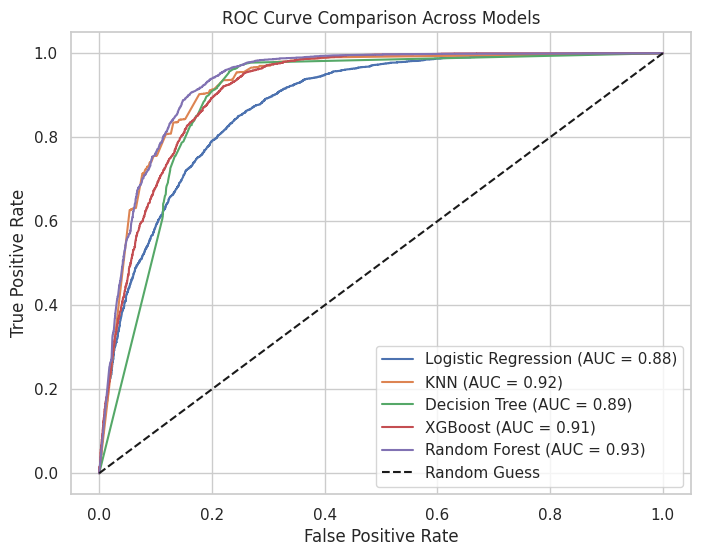

In [87]:
plt.figure(figsize=(8, 6))

# Plot each model’s ROC
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')

# Plot baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Chart settings
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison Across Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [88]:
import pandas as pd

# Example: Convert X_train (array or sparse matrix) back to DataFrame
# Ensure you have the correct feature names
feature_names = preprocessor.get_feature_names_out()  # or whatever gives you the names

# Remove .toarray() since X_train is already a dense array
X_train_df = pd.DataFrame(X_train, columns=feature_names)

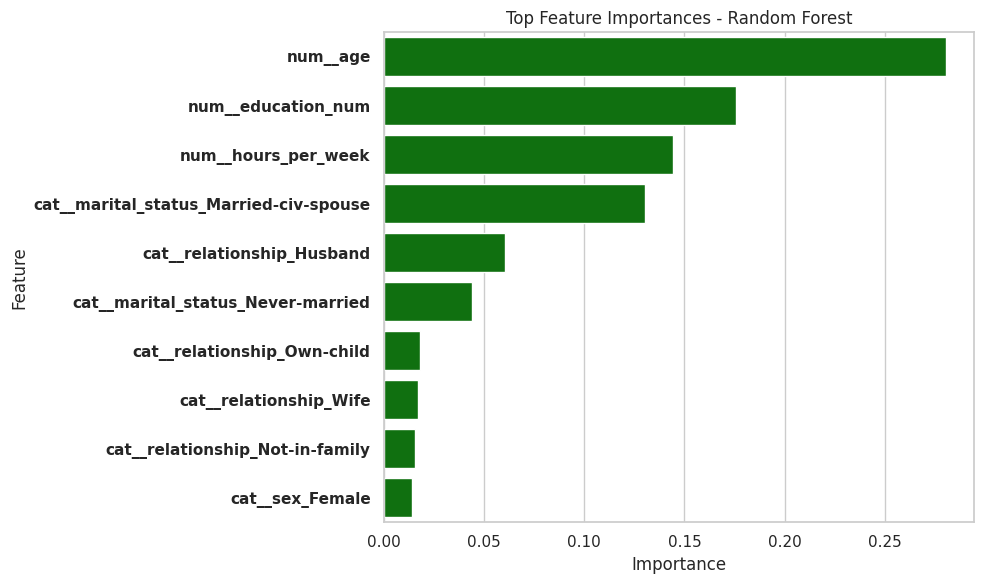

In [89]:
importances = rf_classifier.feature_importances_

# Create feature importance DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X_train_df.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), color='green')
plt.title('Top Feature Importances - Random Forest')

# Make y-axis labels bold
plt.yticks(fontweight='bold')

plt.tight_layout()
plt.show()


# **Model Training on New Features**

## **Logistic Regression**

In [90]:
# Fitting Logistic Regression to df Set
from sklearn. linear_model import LogisticRegression
model_lr = LogisticRegression()
model_lr.fit(X_train_reduced, y_train)

# Making predictions on the Test Set
y_hat_lr = model_lr.predict(X_test_reduced)
# Predicting probabilities
y_hat_prob_lr = model_lr.predict_proba(X_test_reduced)

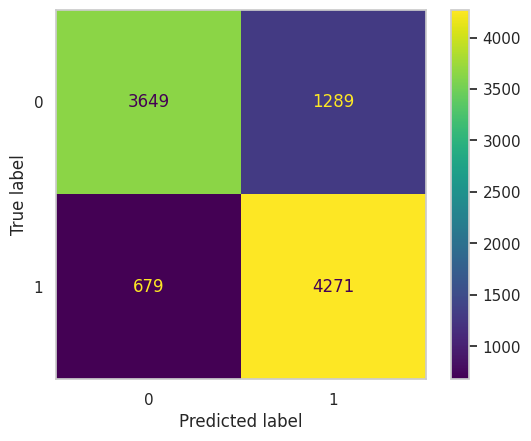

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.74      0.79      4938
           1       0.77      0.86      0.81      4950

    accuracy                           0.80      9888
   macro avg       0.81      0.80      0.80      9888
weighted avg       0.81      0.80      0.80      9888



In [91]:
# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_hat_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(visible=False)
plt.show()

# 4. Classification Report
report = classification_report(y_test, y_hat_lr)
print("Classification Report:")
print(report)

## **KNN**

In [92]:
# Step 1: Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
#
# Step 2: Initialize the KNN model
knn = KNeighborsClassifier()

# Step 3: Train with GridSearchCV and time it
start_time = time.time()
grid_search2 = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search2.fit(X_train_reduced, y_train)
end_time = time.time()

# Step 4: Save the GridSearchCV object with pickle
with open('knn_grid_search_model.pkl', 'wb') as f:
    pickle.dump(grid_search2, f)

# Step 5: Print performance
print(f"GridSearchCV took {end_time - start_time:.2f} seconds.")
print("Best Hyperparameters:", grid_search2.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
GridSearchCV took 401.55 seconds.
Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}


In [93]:
# Step 6: Predict and evaluate
best_knn = grid_search2.best_estimator_
y_pred = best_knn.predict(X_test_reduced)
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy Score: 0.8461771844660194

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.77      0.83      4938
           1       0.80      0.93      0.86      4950

    accuracy                           0.85      9888
   macro avg       0.86      0.85      0.85      9888
weighted avg       0.86      0.85      0.85      9888


Confusion Matrix:
 [[3785 1153]
 [ 368 4582]]


## **Decision Tree**

In [94]:
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
# 3. Initialize and Train Model with GridSearchCV
dtree = DecisionTreeClassifier(random_state=42)

start = time.time()
grid_search_dt = GridSearchCV(dtree, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search_dt.fit(X_train_reduced, y_train)
end = time.time()

print(f"GridSearch completed in {(end - start):.2f} seconds")
print("Best Hyperparameters:", grid_search_dt.best_params_)

# Step 4: Predict and Evaluate
best_dt = grid_search_dt.best_estimator_
y_pred = best_dt.predict(X_test_reduced)

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Step 5: Save the Model
with open('decision_tree_model.pkl', 'wb') as f:
    pickle.dump(grid_search_dt, f)
print("Model saved as decision_tree_model.pkl")



Fitting 5 folds for each of 24 candidates, totalling 120 fits
GridSearch completed in 9.55 seconds
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}
Accuracy Score: 0.8560881877022654

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.78      0.84      4938
           1       0.81      0.93      0.87      4950

    accuracy                           0.86      9888
   macro avg       0.86      0.86      0.86      9888
weighted avg       0.86      0.86      0.86      9888


Confusion Matrix:
 [[3865 1073]
 [ 350 4600]]
Model saved as decision_tree_model.pkl


## **XG Boost**

In [95]:
# Step 3: Define Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.8, 1.0]
}

# Step 4: Train XGBoost with GridSearchCV
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

start = time.time()
grid_search_xgb = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search_xgb.fit(X_train_reduced, y_train)
end = time.time()

print(f"GridSearchCV completed in {(end - start):.2f} seconds")
print("Best Hyperparameters:", grid_search_xgb.best_params_)

# Step 5: Predict and Evaluate
best_xgb = grid_search_xgb.best_estimator_
y_pred = best_xgb.predict(X_test_reduced)

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
GridSearchCV completed in 97.39 seconds
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Accuracy Score: 0.8275687702265372

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.76      0.82      4938
           1       0.79      0.89      0.84      4950

    accuracy                           0.83      9888
   macro avg       0.83      0.83      0.83      9888
weighted avg       0.83      0.83      0.83      9888


Confusion Matrix:
 [[3772 1166]
 [ 539 4411]]


## **Random Forest**

In [96]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'criterion': ['gini', 'entropy']
}


# Initialize and Train Model with GridSearchCV
rf = RandomForestClassifier(random_state=42)

start = time.time()
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', verbose=1)
grid_search_rf.fit(X_train_reduced, y_train)
end = time.time()

print(f"GridSearch completed in {(end - start):.2f} seconds")
print("Best Hyperparameters:", grid_search_rf.best_params_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
GridSearch completed in 387.08 seconds
Best Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [97]:
# Step 5: Predict and Evaluate
best_r = grid_search_rf.best_estimator_
y_pred_r = best_r.predict(X_test_reduced)

print("Accuracy Score:", accuracy_score(y_test, y_pred_r))
print("\nClassification Report:\n", classification_report(y_test, y_pred_r))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_r))

Accuracy Score: 0.8644822006472492

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.79      0.85      4938
           1       0.82      0.94      0.87      4950

    accuracy                           0.86      9888
   macro avg       0.87      0.86      0.86      9888
weighted avg       0.87      0.86      0.86      9888


Confusion Matrix:
 [[3899 1039]
 [ 301 4649]]


# ROC/AUC for all models on Reduced

In [98]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

# 1. Get probabilities for ROC (only the positive class, i.e., [:, 1])
# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_hat_prob_lr[:, 1])
auc_lr = auc(fpr_lr, tpr_lr)

# KNN (some versions use .predict_proba)
fpr_knn, tpr_knn, _ = roc_curve(y_test, best_knn.predict_proba(X_test_reduced)[:, 1])
auc_knn = auc(fpr_knn, tpr_knn)

# Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, best_dt.predict_proba(X_test_reduced)[:, 1])
auc_dt = auc(fpr_dt, tpr_dt)

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, best_xgb.predict_proba(X_test_reduced)[:, 1])
auc_xgb = auc(fpr_xgb, tpr_xgb)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, best_r.predict_proba(X_test_reduced)[:, 1])
auc_rf = auc(fpr_rf, tpr_rf)

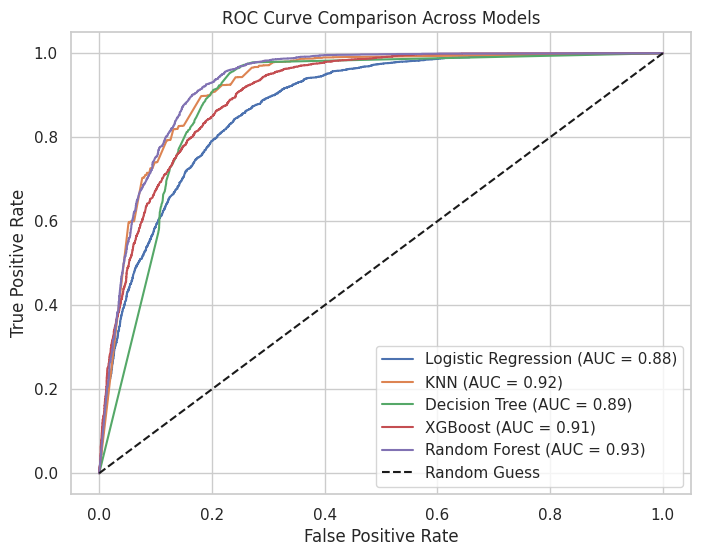

In [99]:
plt.figure(figsize=(8, 6))

# Plot each model’s ROC
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')

# Plot baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Chart settings
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison Across Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()